In [1]:
import SIMSIToolBox
import os
import matplotlib.pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser, getionimage
import importlib
importlib.reload(SIMSIToolBox)
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from copy import deepcopy

In [2]:
inpath = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/non-perfused/desi/"
labeledFile = "13C/20221107_mt_tumor_brain4-4_13B_13C_20um_70-560mz Analyte 1_1_recal.imzML"
unlabeledFile = "12C/20221113_mt_tumor_brain2-3_05L_12C_20um_70-560mz Analyte 1_v2_1_recal.imzML"
#fns = [x for x in os.listdir(inpath + "12C") if ".imzML" in x]
#fns

In [3]:
fns = [labeledFile,unlabeledFile]
labels = ["U13C-Glucose","unlabeled"]
intensityCutoff = 100
ppm = 10
numCores = 20
dm_method = "PCA" #method for dimensionality reduction ("PCA" or "TSNE") PCA has worked better for me
seg_method = "K_means" #thresholding method ("TIC_auto", "K_means", "TIC_manual")
num_components = 2 #number of compoents to use with PCA or TSNE
colormap = LinearSegmentedColormap.from_list("test",colors=["black", "navy","blue","cyan","yellow","orange","orangered","red","mistyrose","white"],N=256)


In [4]:
boxSize = 10
boxBoundaries = [{"i":[[150,150+boxSize],[45,45+boxSize]],"c":[[70,70+boxSize],[45,45+boxSize]]},
                {"i":[[170,170+boxSize],[45,45+boxSize]],"c":[[60,60+boxSize],[45,45+boxSize]]}]

In [5]:
def plotBox(xmin,xmax,ymin,ymax,color):
    plt.plot([xmin,xmax],[ymin,ymin],color)
    plt.plot([xmin,xmax],[ymax,ymax],color)
    plt.plot([xmin,xmin],[ymin,ymax],color)
    plt.plot([xmax,xmax],[ymin,ymax],color)

In [6]:
imgs = []
ps = []
meanTics = []
for file in fns:
    p = ImzMLParser(inpath + file) #load data
    img = getionimage(p,174.0407175,0.01)
    ticImage = getionimage(p,500,1000)
    meanTic = np.median(ticImage)
    imgs.append(img)
    ps.append(p)
    meanTics.append(meanTic)

In [7]:
meanTics

[449096.5, 232709.0]

In [8]:
factors = meanTics / meanTics[1]
factors

array([1.92986305, 1.        ])

464765.6820701357

1379 m/z values detected in box1 of U13C-Glucose
1945 m/z values detected in box2 of U13C-Glucose
264472.3350757233

996 m/z values detected in box1 of unlabeled
706 m/z values detected in box2 of unlabeled


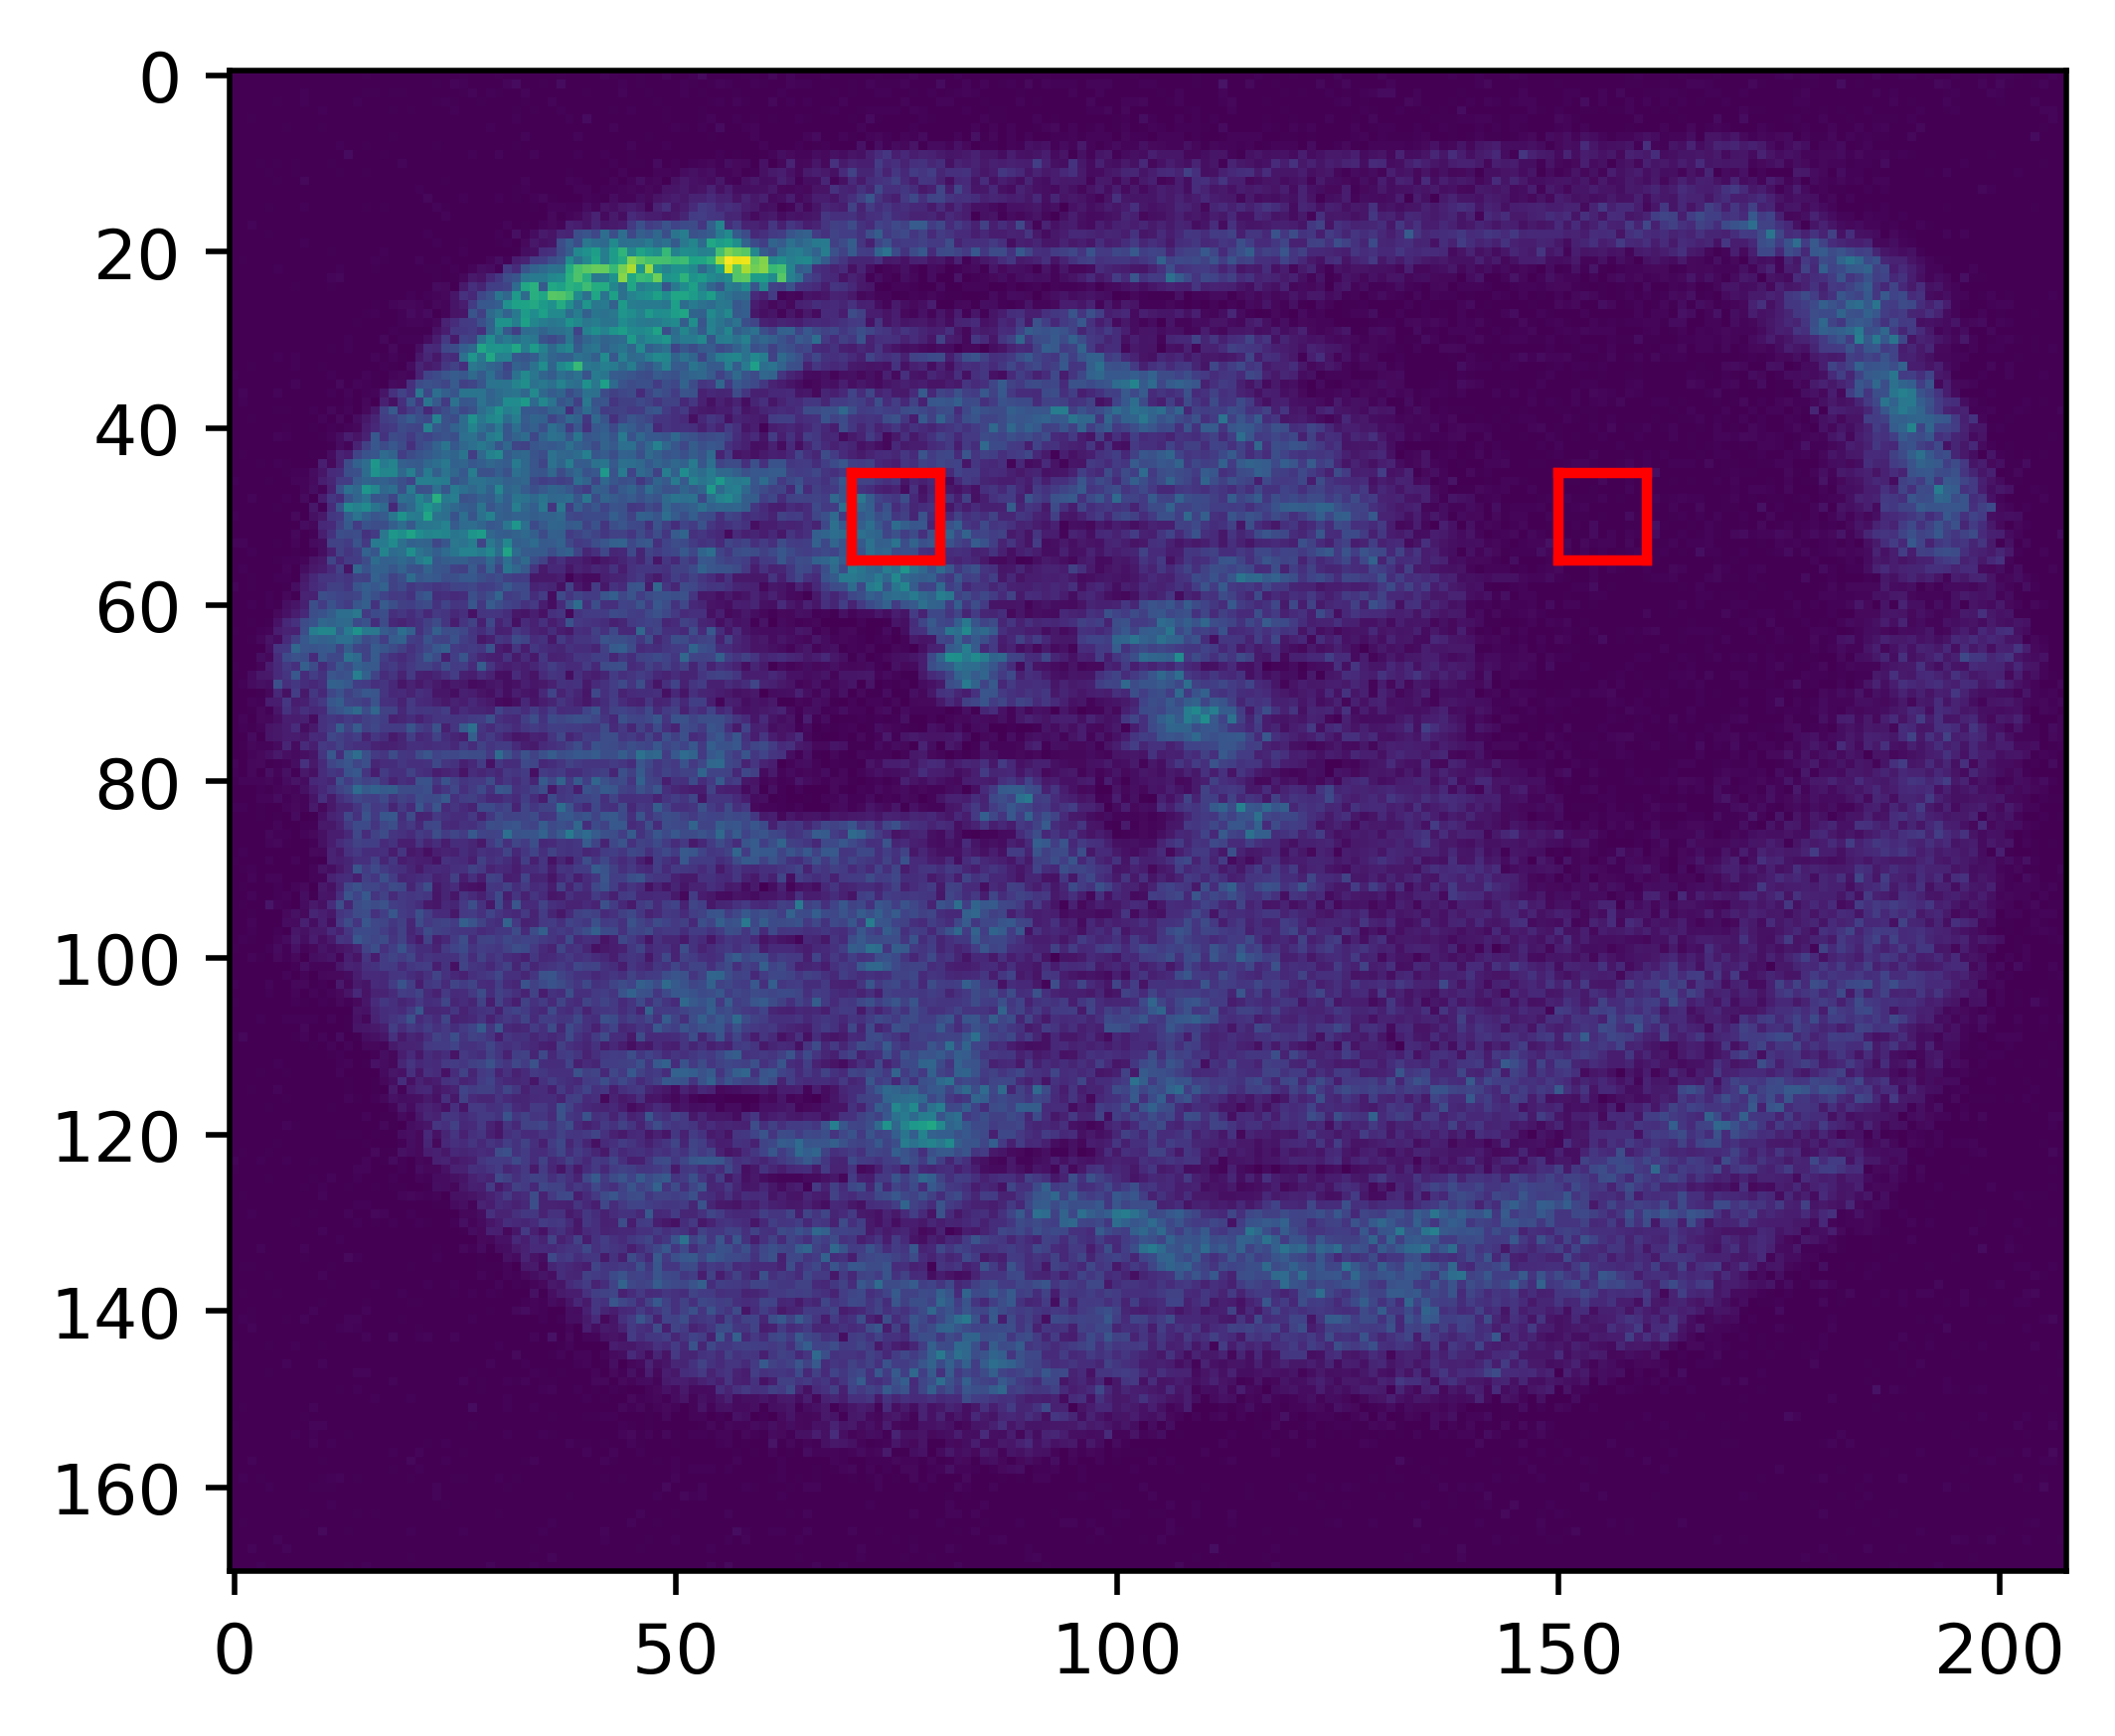

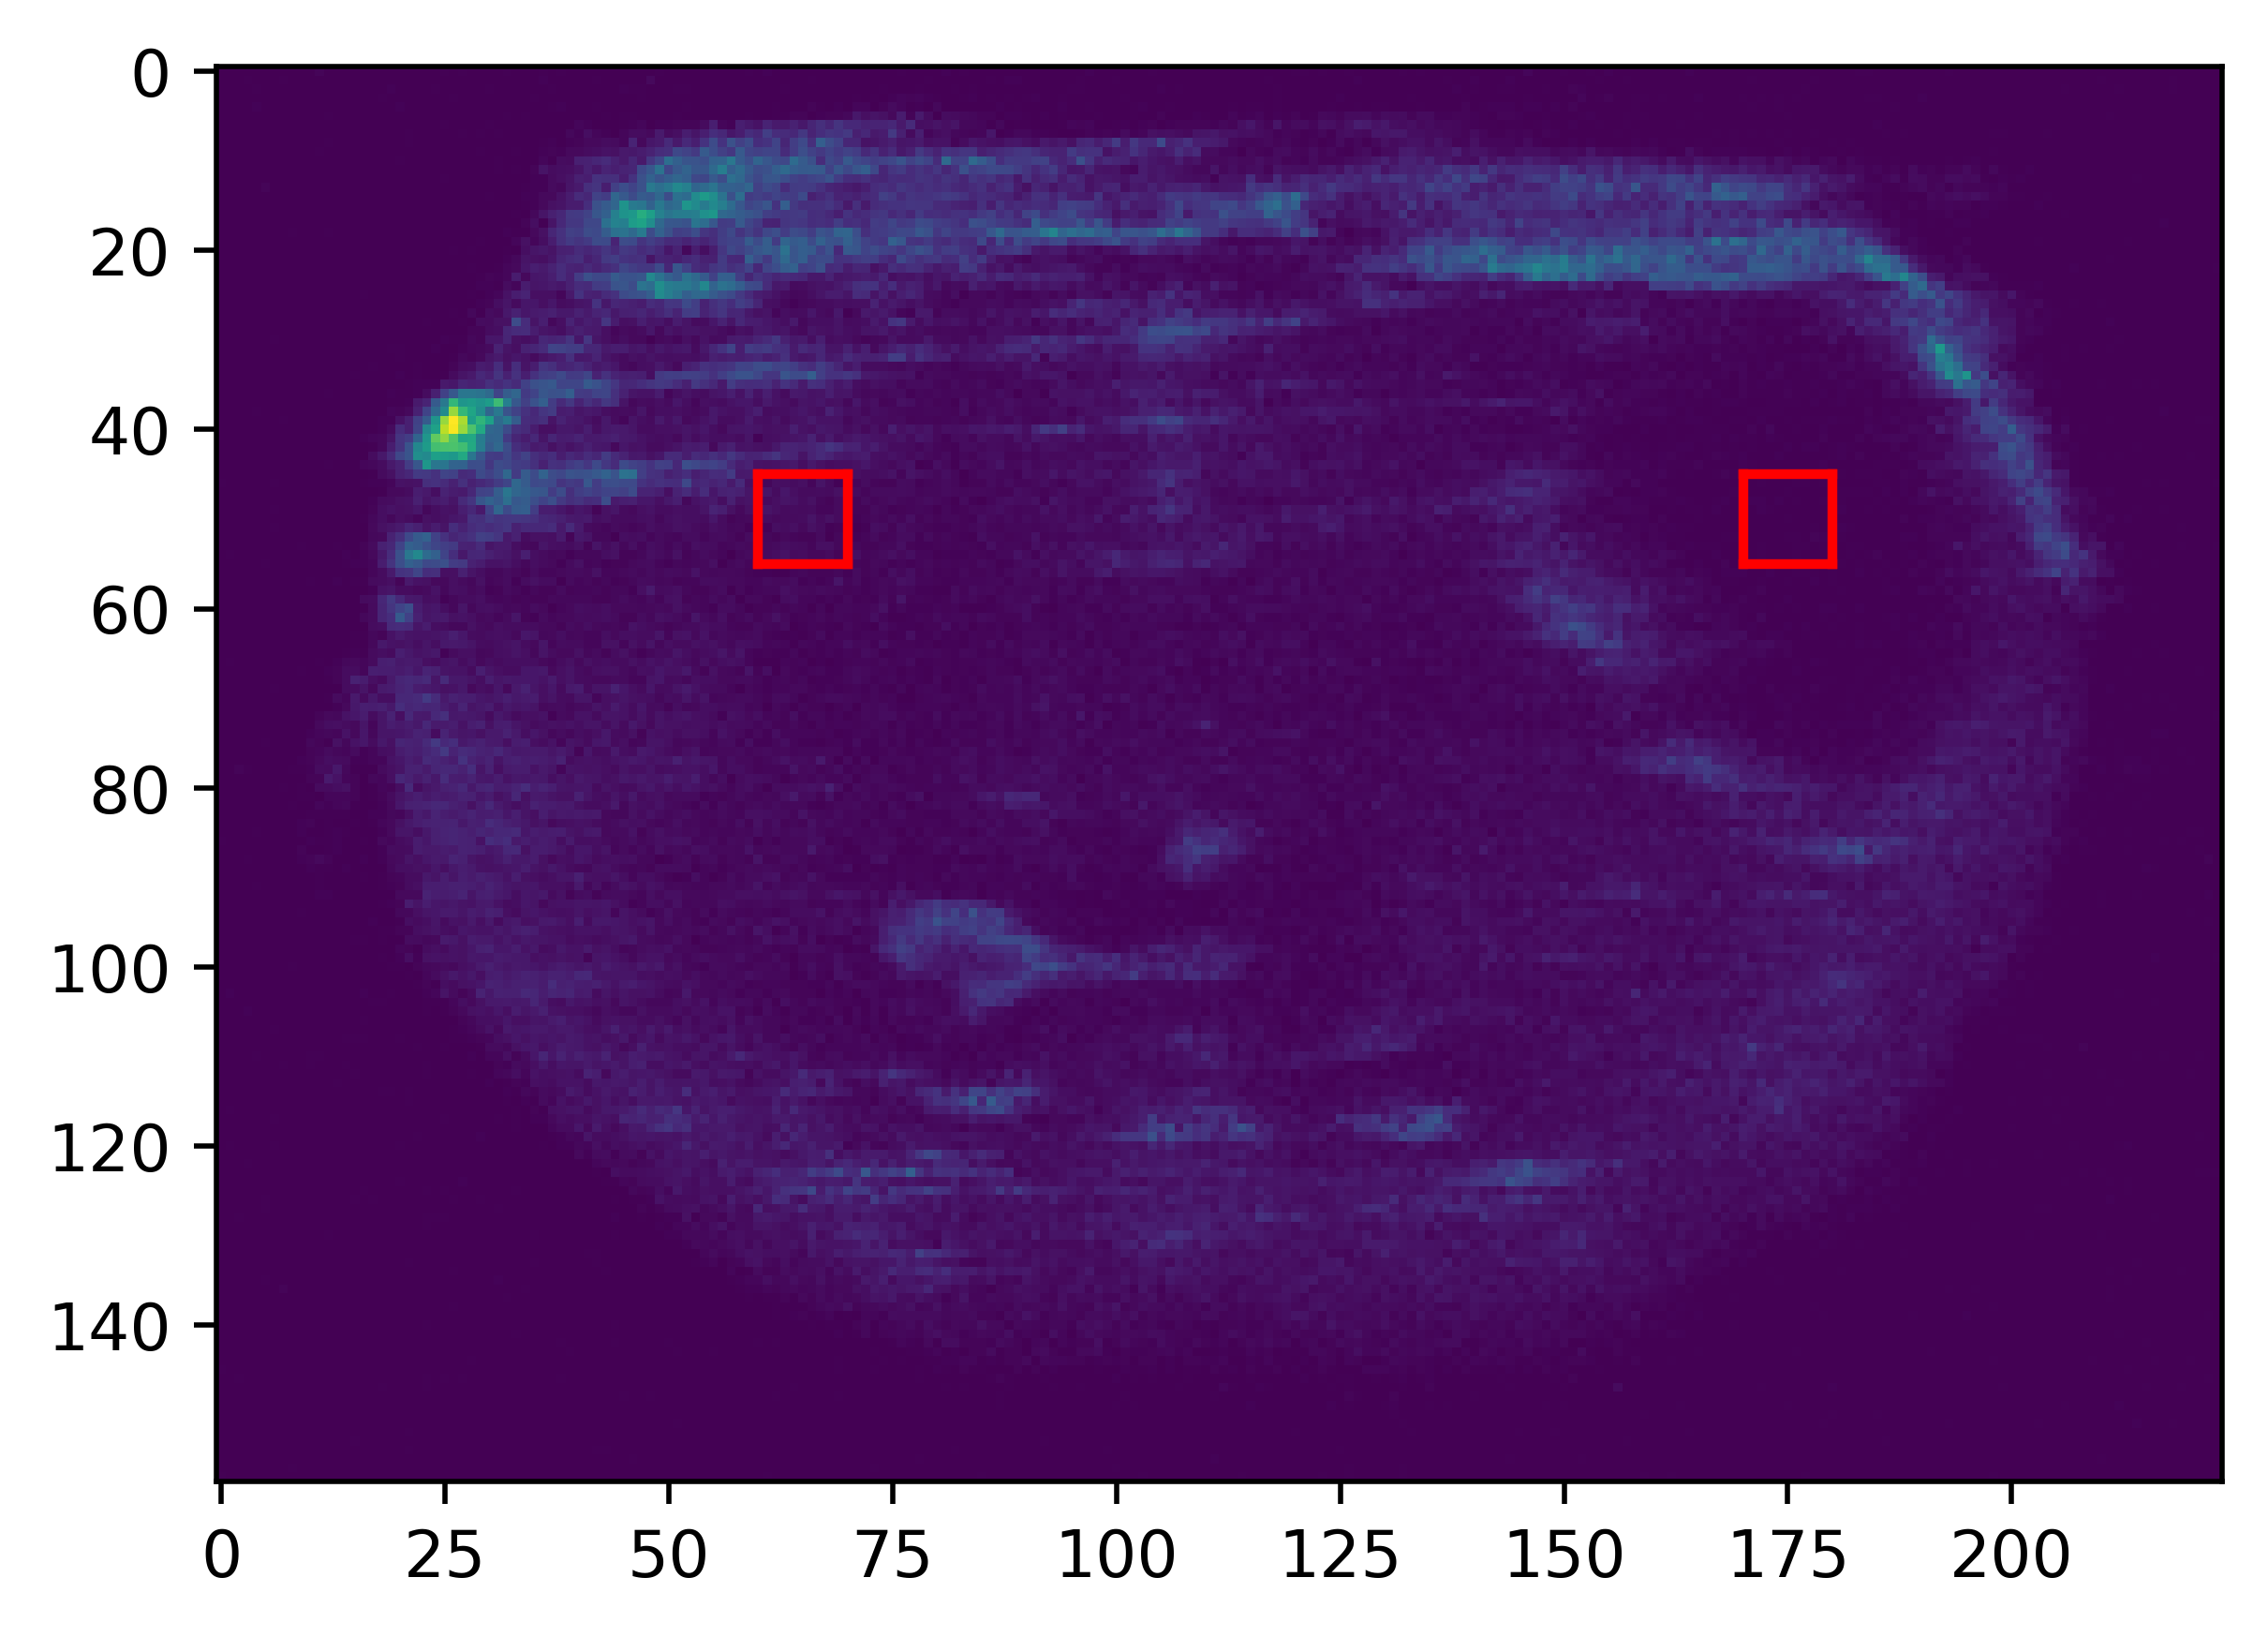

In [9]:
mzLists = []
for file,label,bound,img,p,factor in zip(fns,labels,boxBoundaries,imgs,ps,factors):
    
    plt.figure()
    plt.imshow(img)
    
    box1 = bound["i"]
    box2 = bound["c"]

    plotBox(*box1[0],*box1[1],"red")
    plotBox(*box2[0],*box2[1],"red")
    

    #gather mzs of interest
    mzList = [[],[]]
    i = 0
    
    ticImage = getionimage(p,500,1000)
    meanTic = np.mean(ticImage)
    print(meanTic)
    
    for idx, (x,y,z) in enumerate(p.coordinates):
        if y-1 > box1[1][0] and y-1 < box1[1][1] and x-1 > box1[0][0] and x-1 < box1[0][1]:
            mzs, intensities = p.getspectrum(idx)
            tmp = intensityCutoff# * factor 
            intensities = intensities# / np.sum(intensities) * meanTic            
            mzs = [mzs[x] for x in range(len(mzs)) if intensities[x] > tmp]
            mzList[0] = SIMSIToolBox.mergeMzLists(mzList[0],mzs,ppm)
        if y-1 > box2[1][0] and y-1 < box2[1][1] and x-1 > box2[0][0] and x-1 < box2[0][1]:
            mzs, intensities = p.getspectrum(idx)
            tmp = intensityCutoff# * factor 
            intensities = intensities# / np.sum(intensities) * meanTic
            mzs = [mzs[x] for x in range(len(mzs)) if intensities[x] > tmp]
            mzList[1] = SIMSIToolBox.mergeMzLists(mzList[1],mzs,ppm)
        #SIMSIToolBox.printProgressBar(i,len(p.coordinates), "gathering mzs",printEnd="")
        i += 1
        
    mzList[0].sort()
    mzList[1].sort()
    mzLists.append(mzList)
    print()
    print(len(mzList[0]), "m/z values detected in box1 of " + label)
    print(len(mzList[1]), "m/z values detected in box2 of " + label)


extracting intensities |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
extracting intensities |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
extracting intensities |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
extracting intensities |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


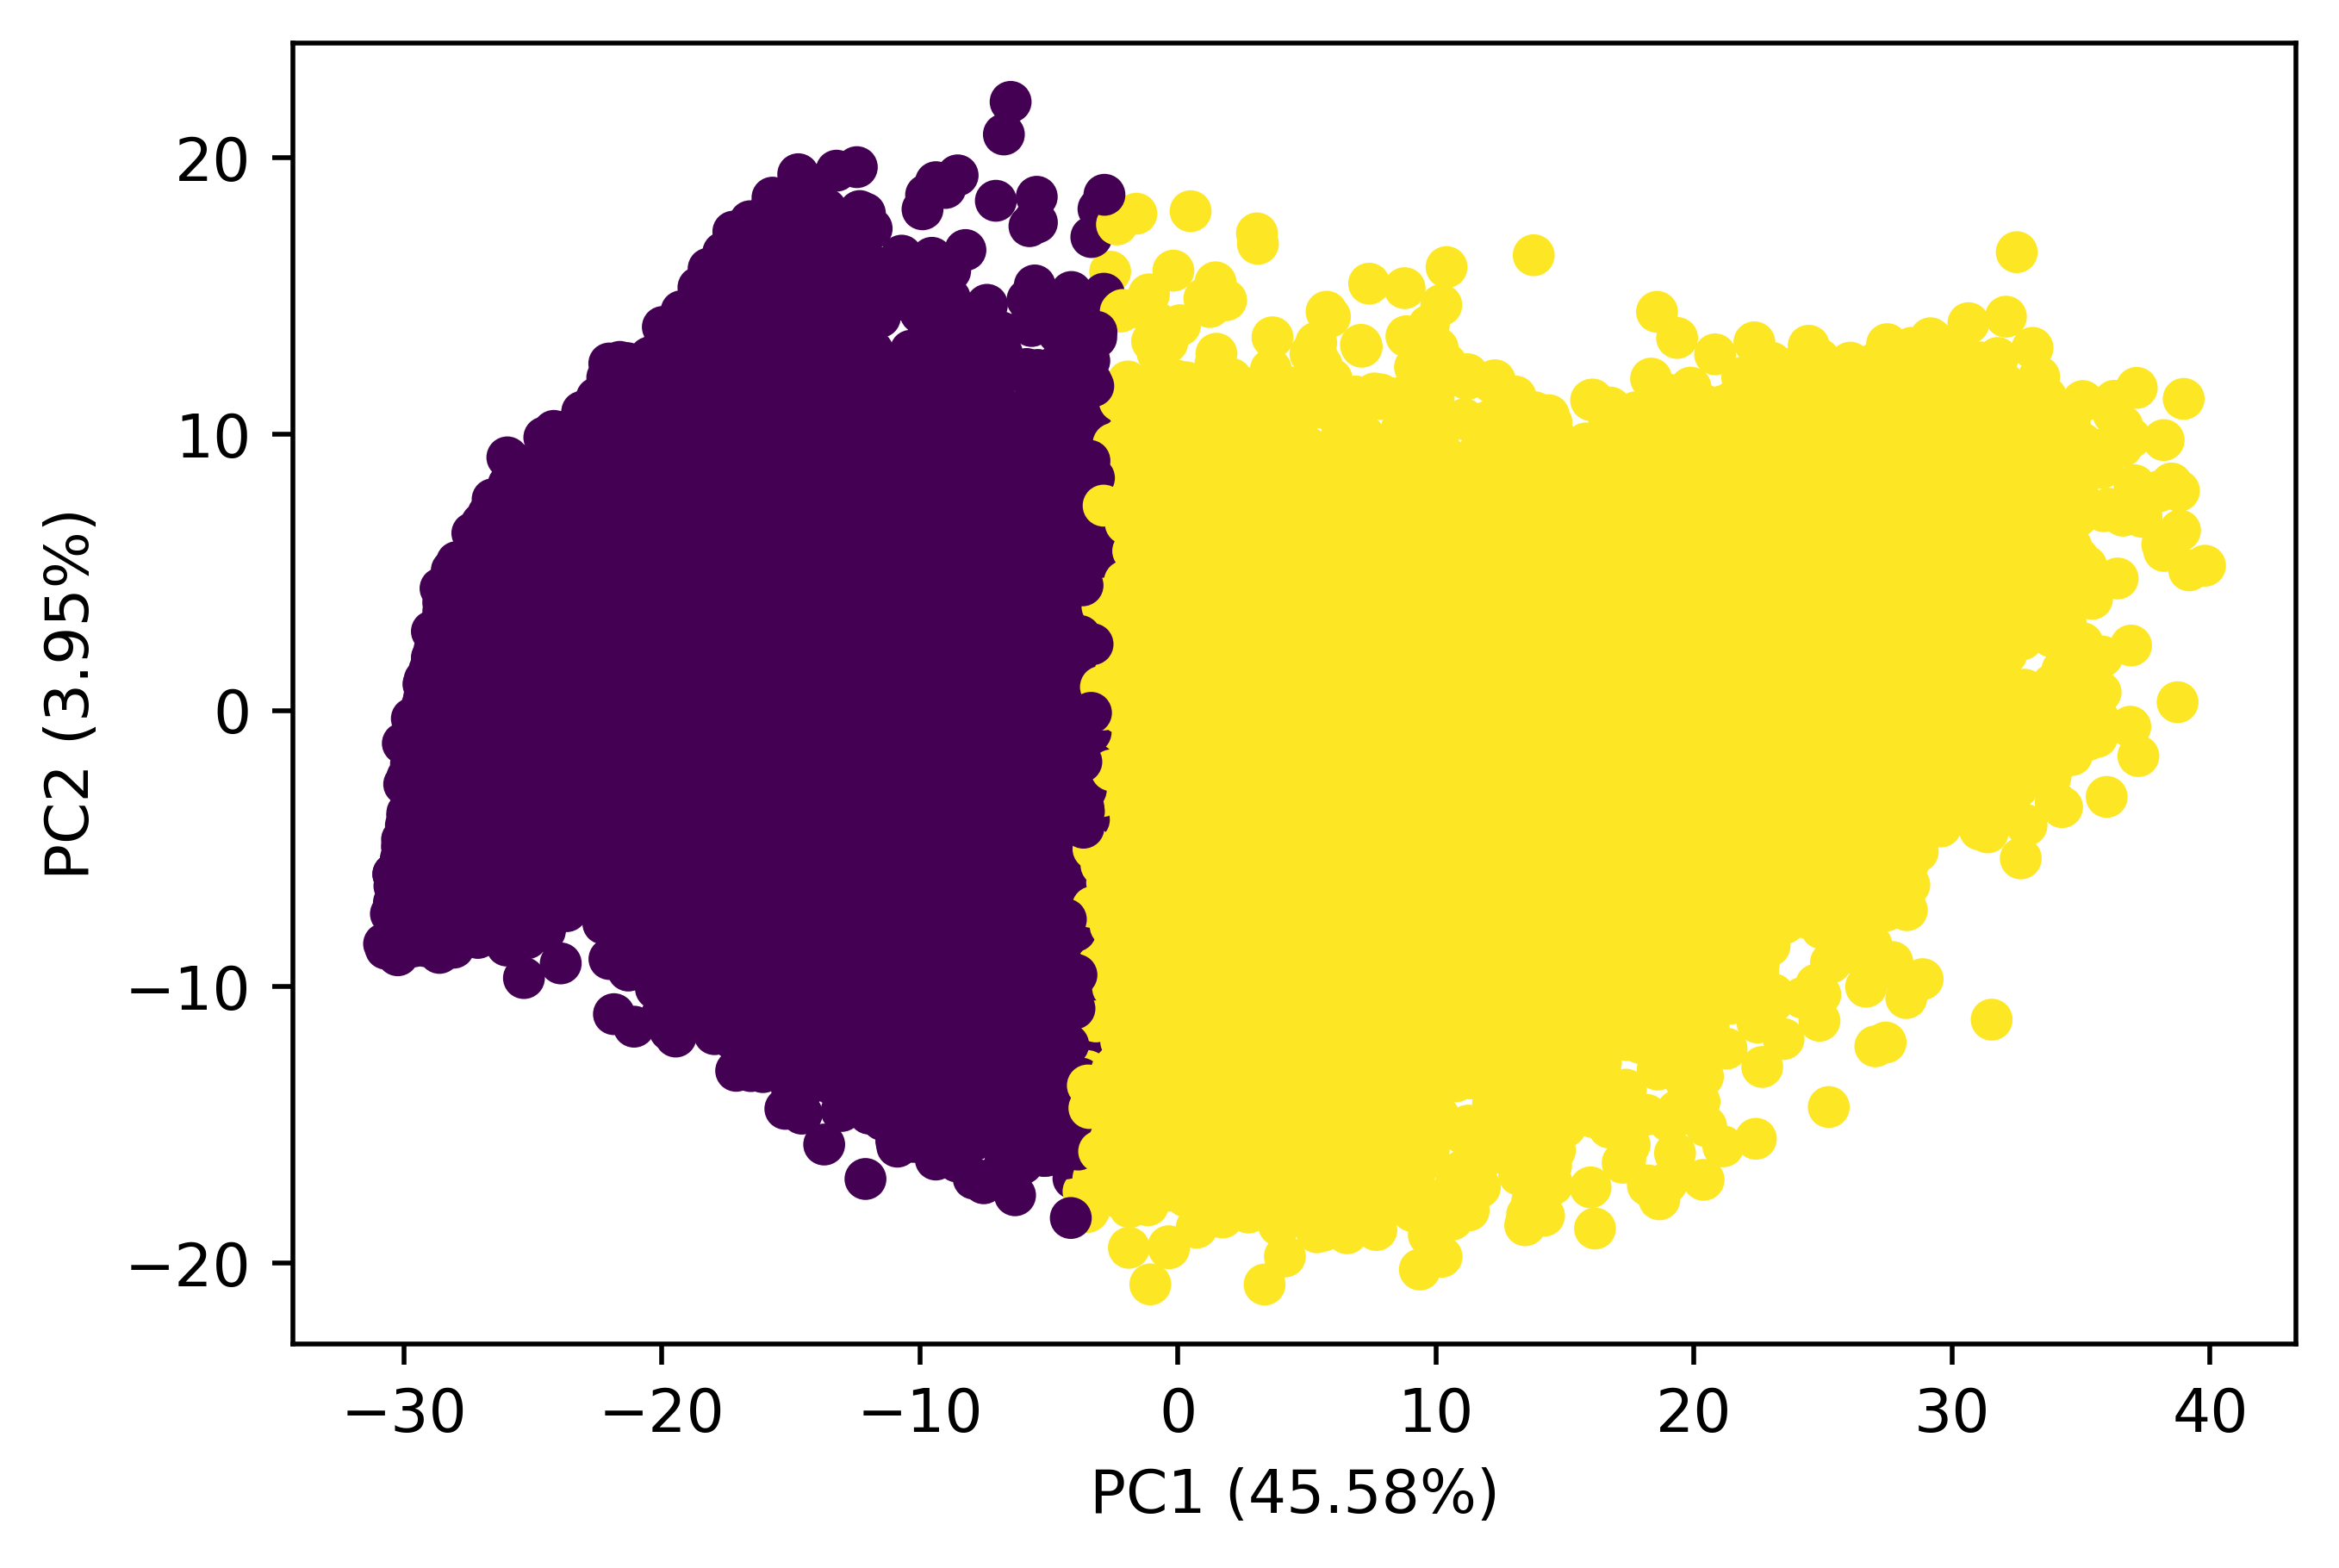

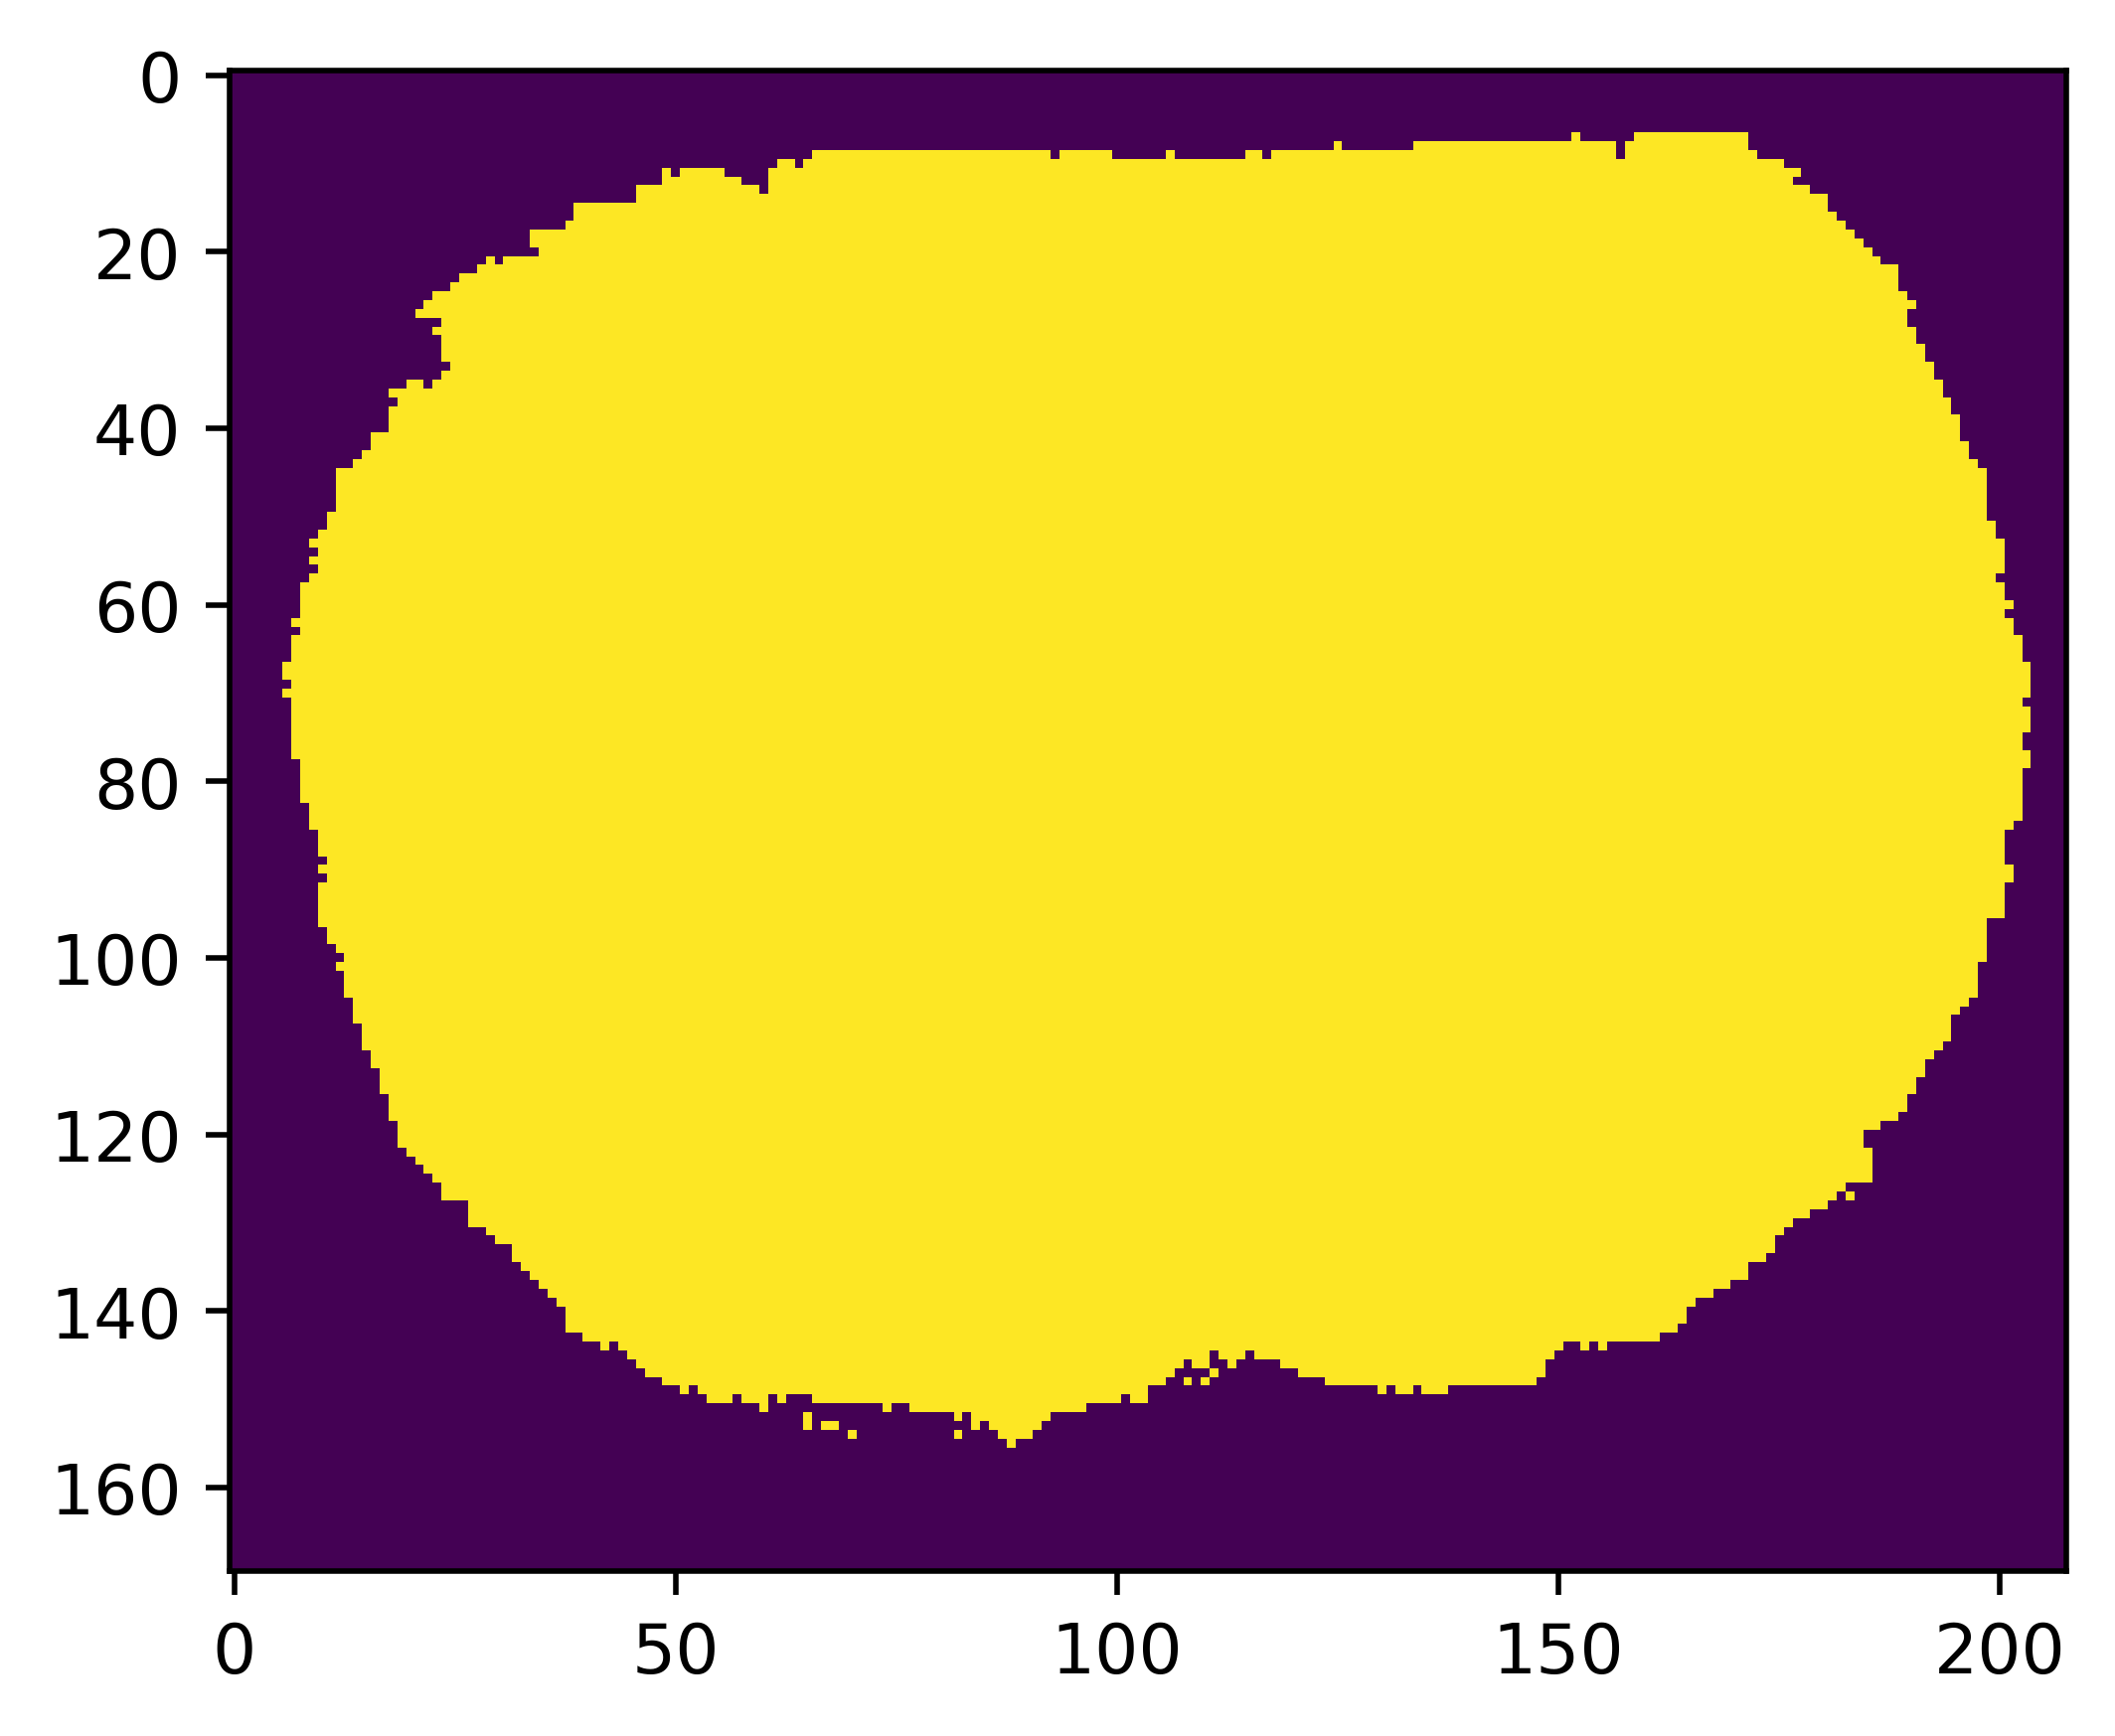

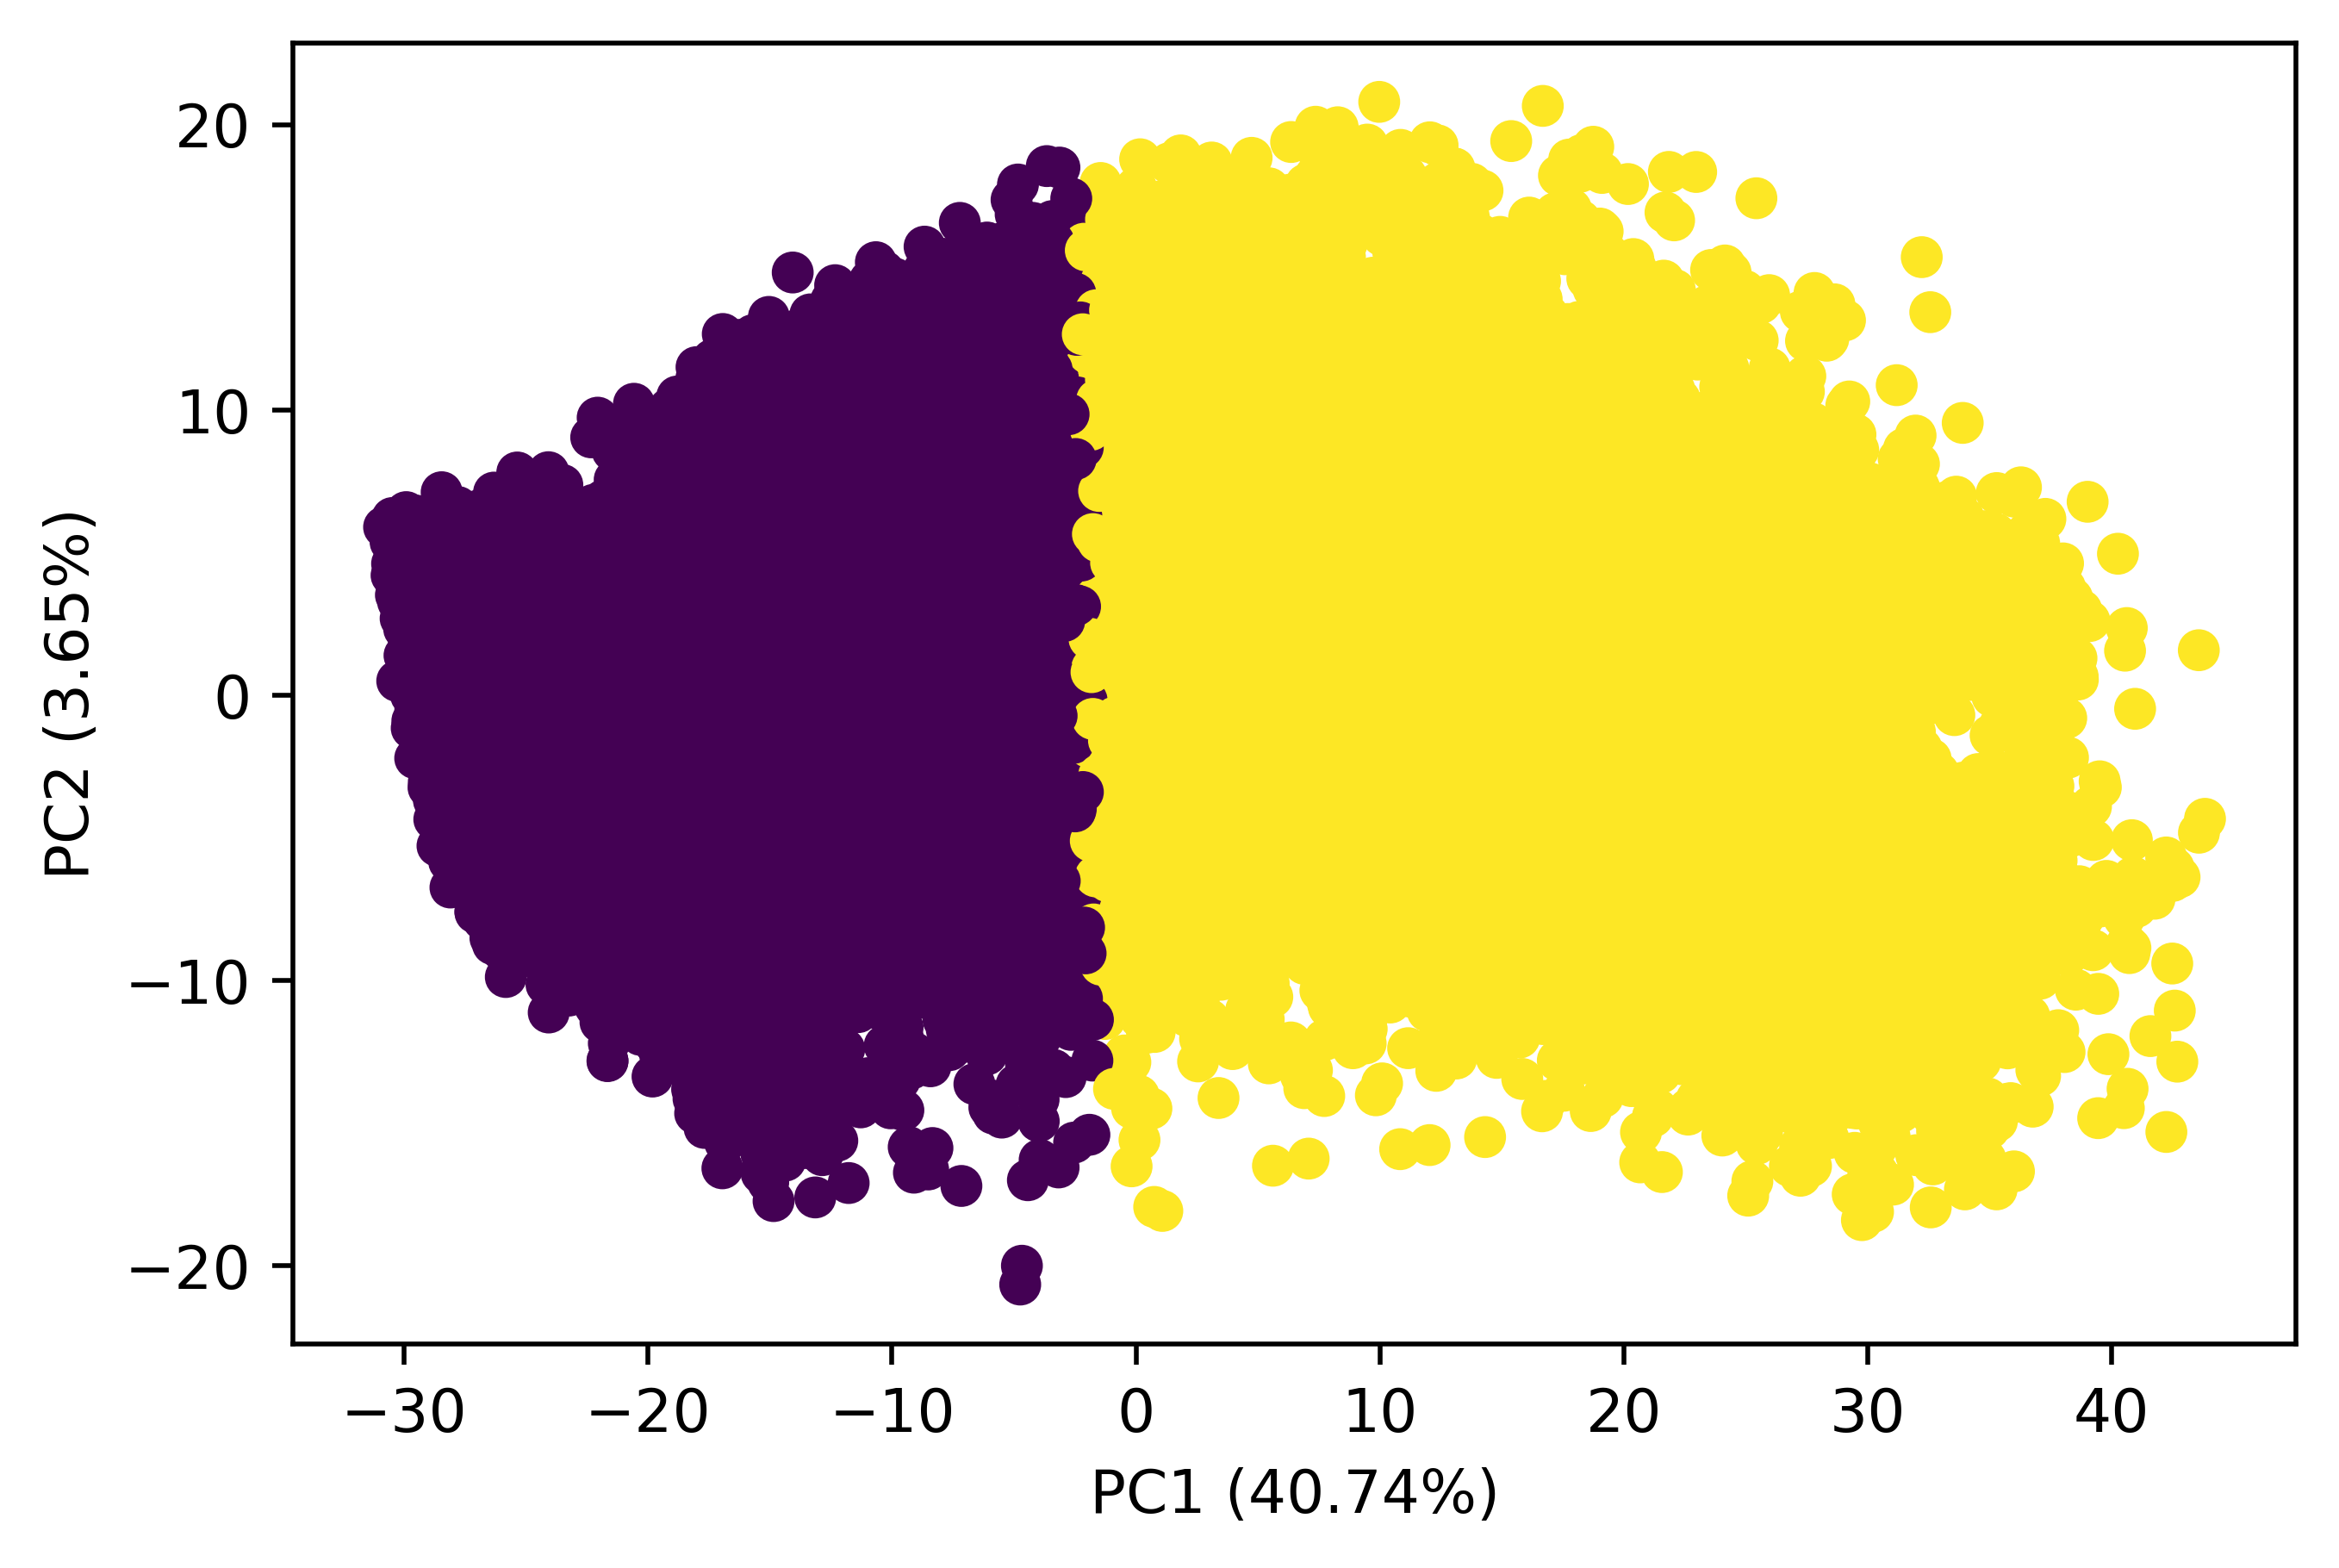

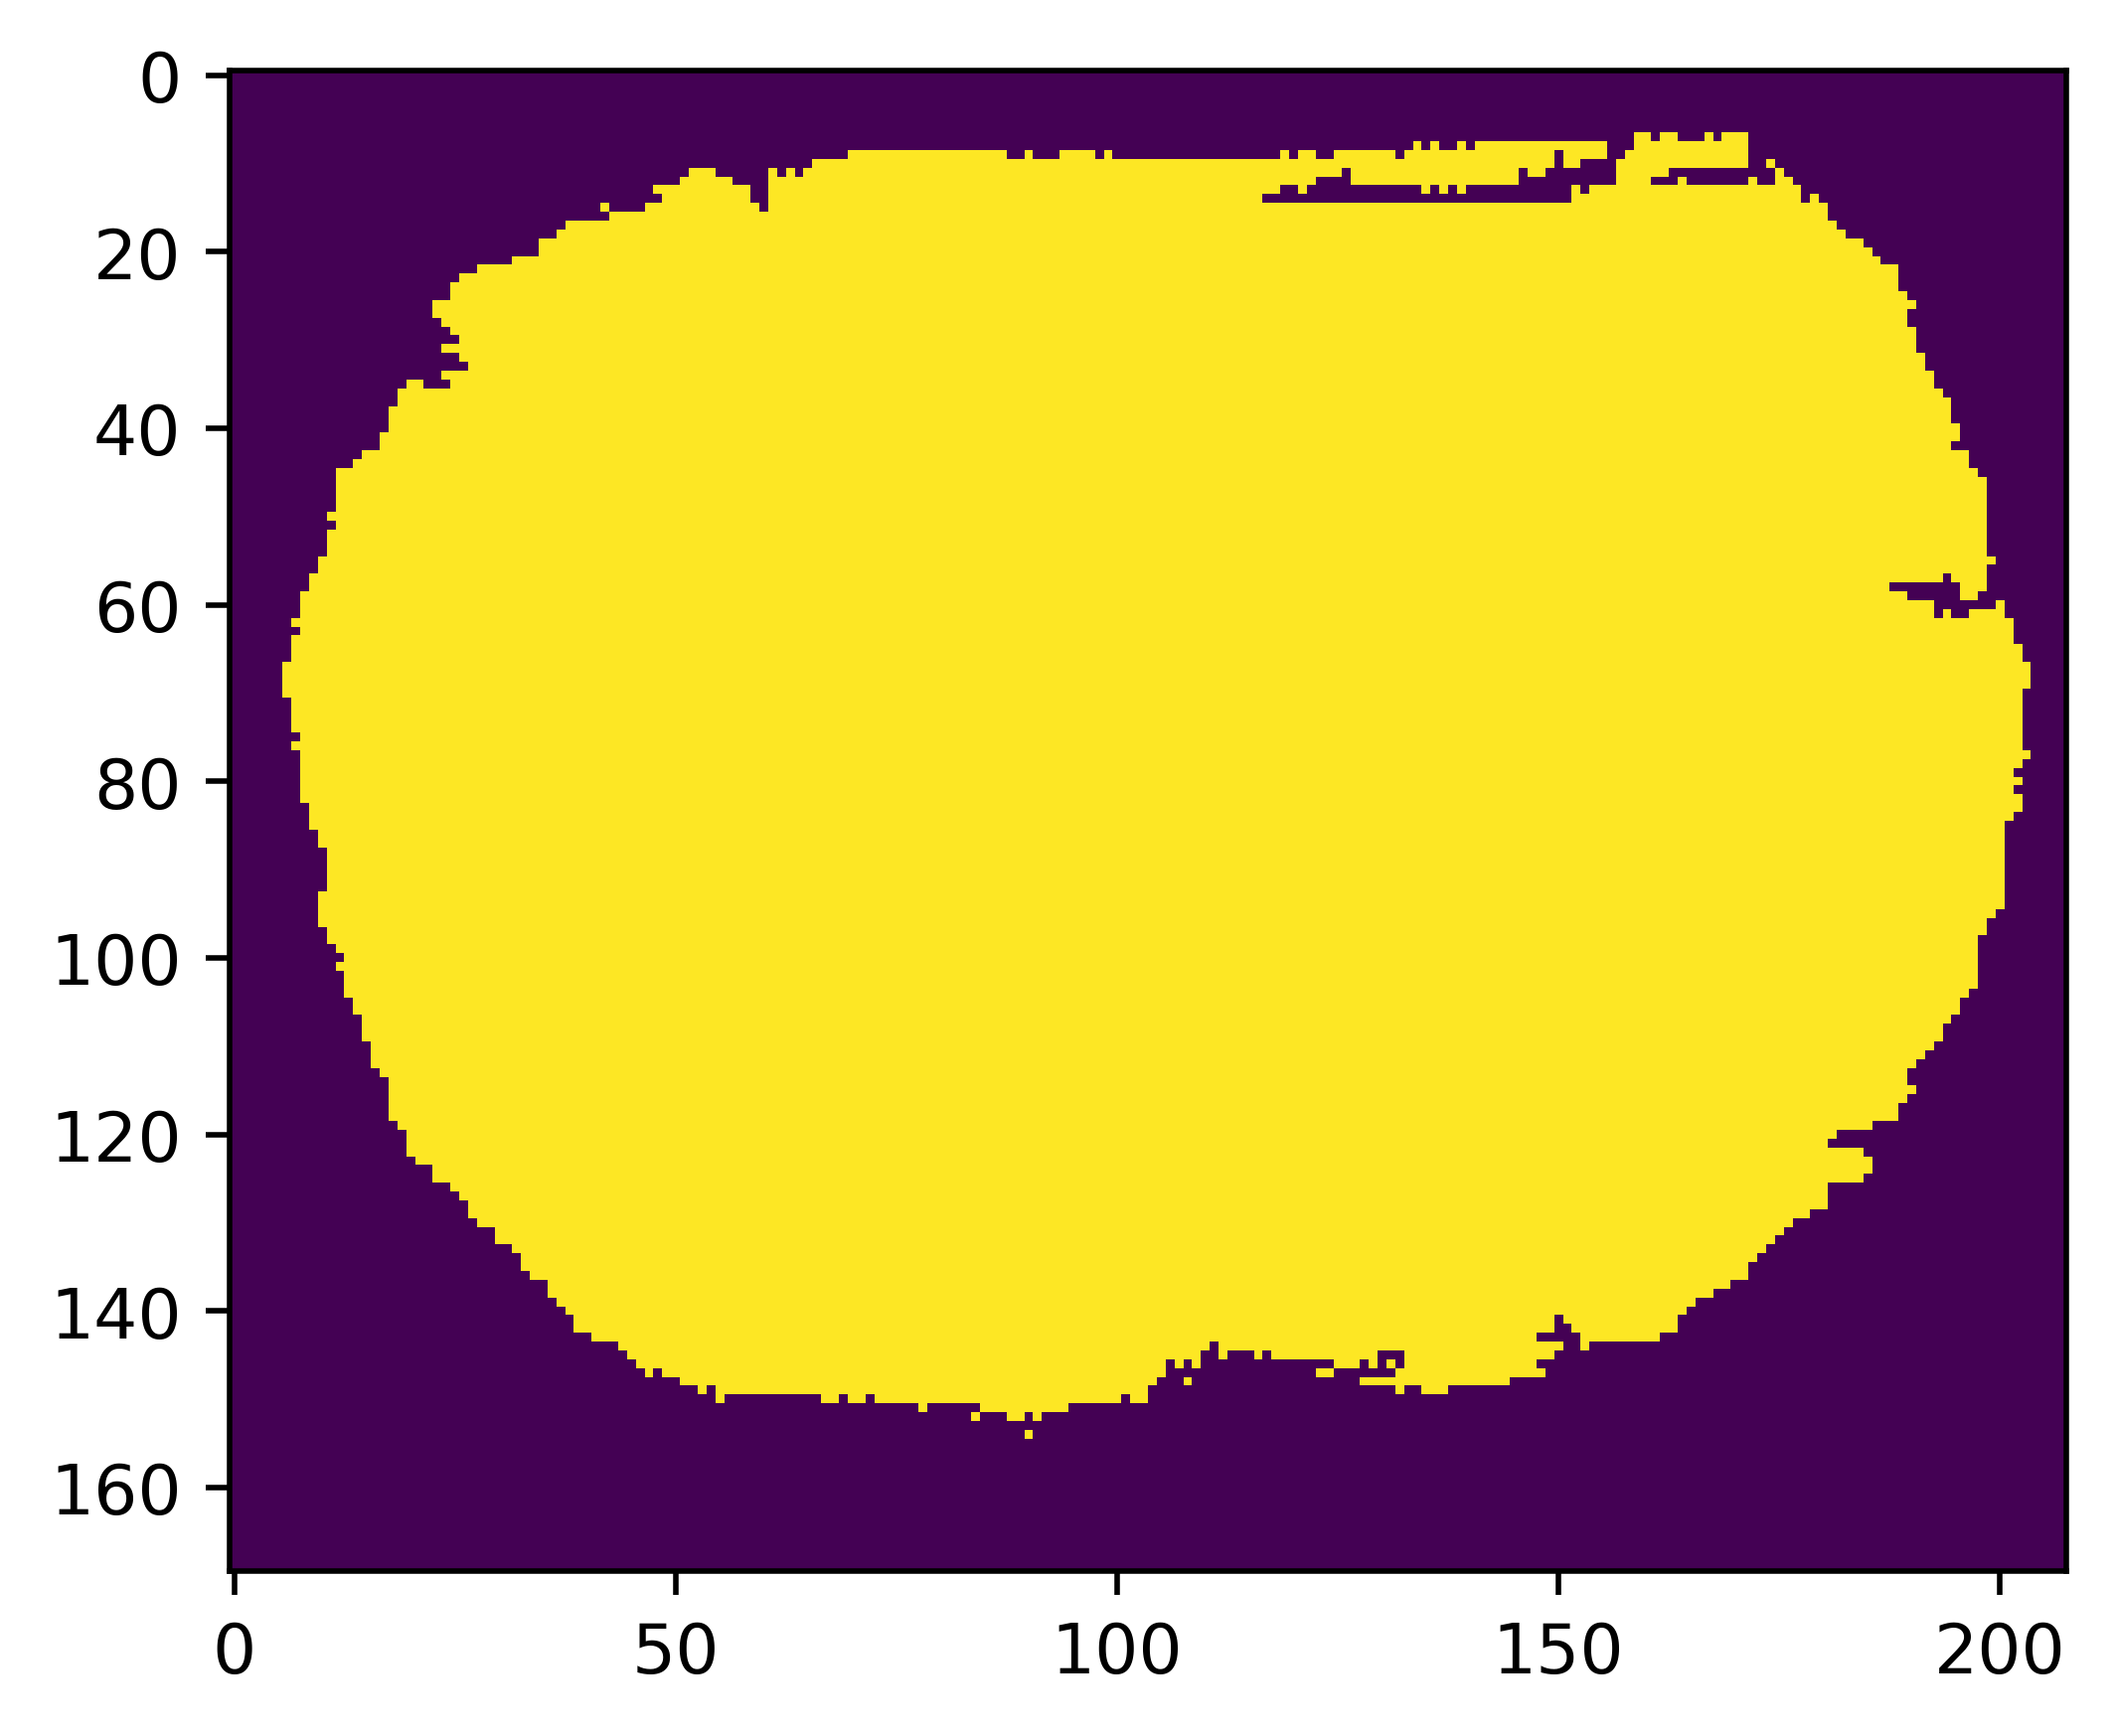

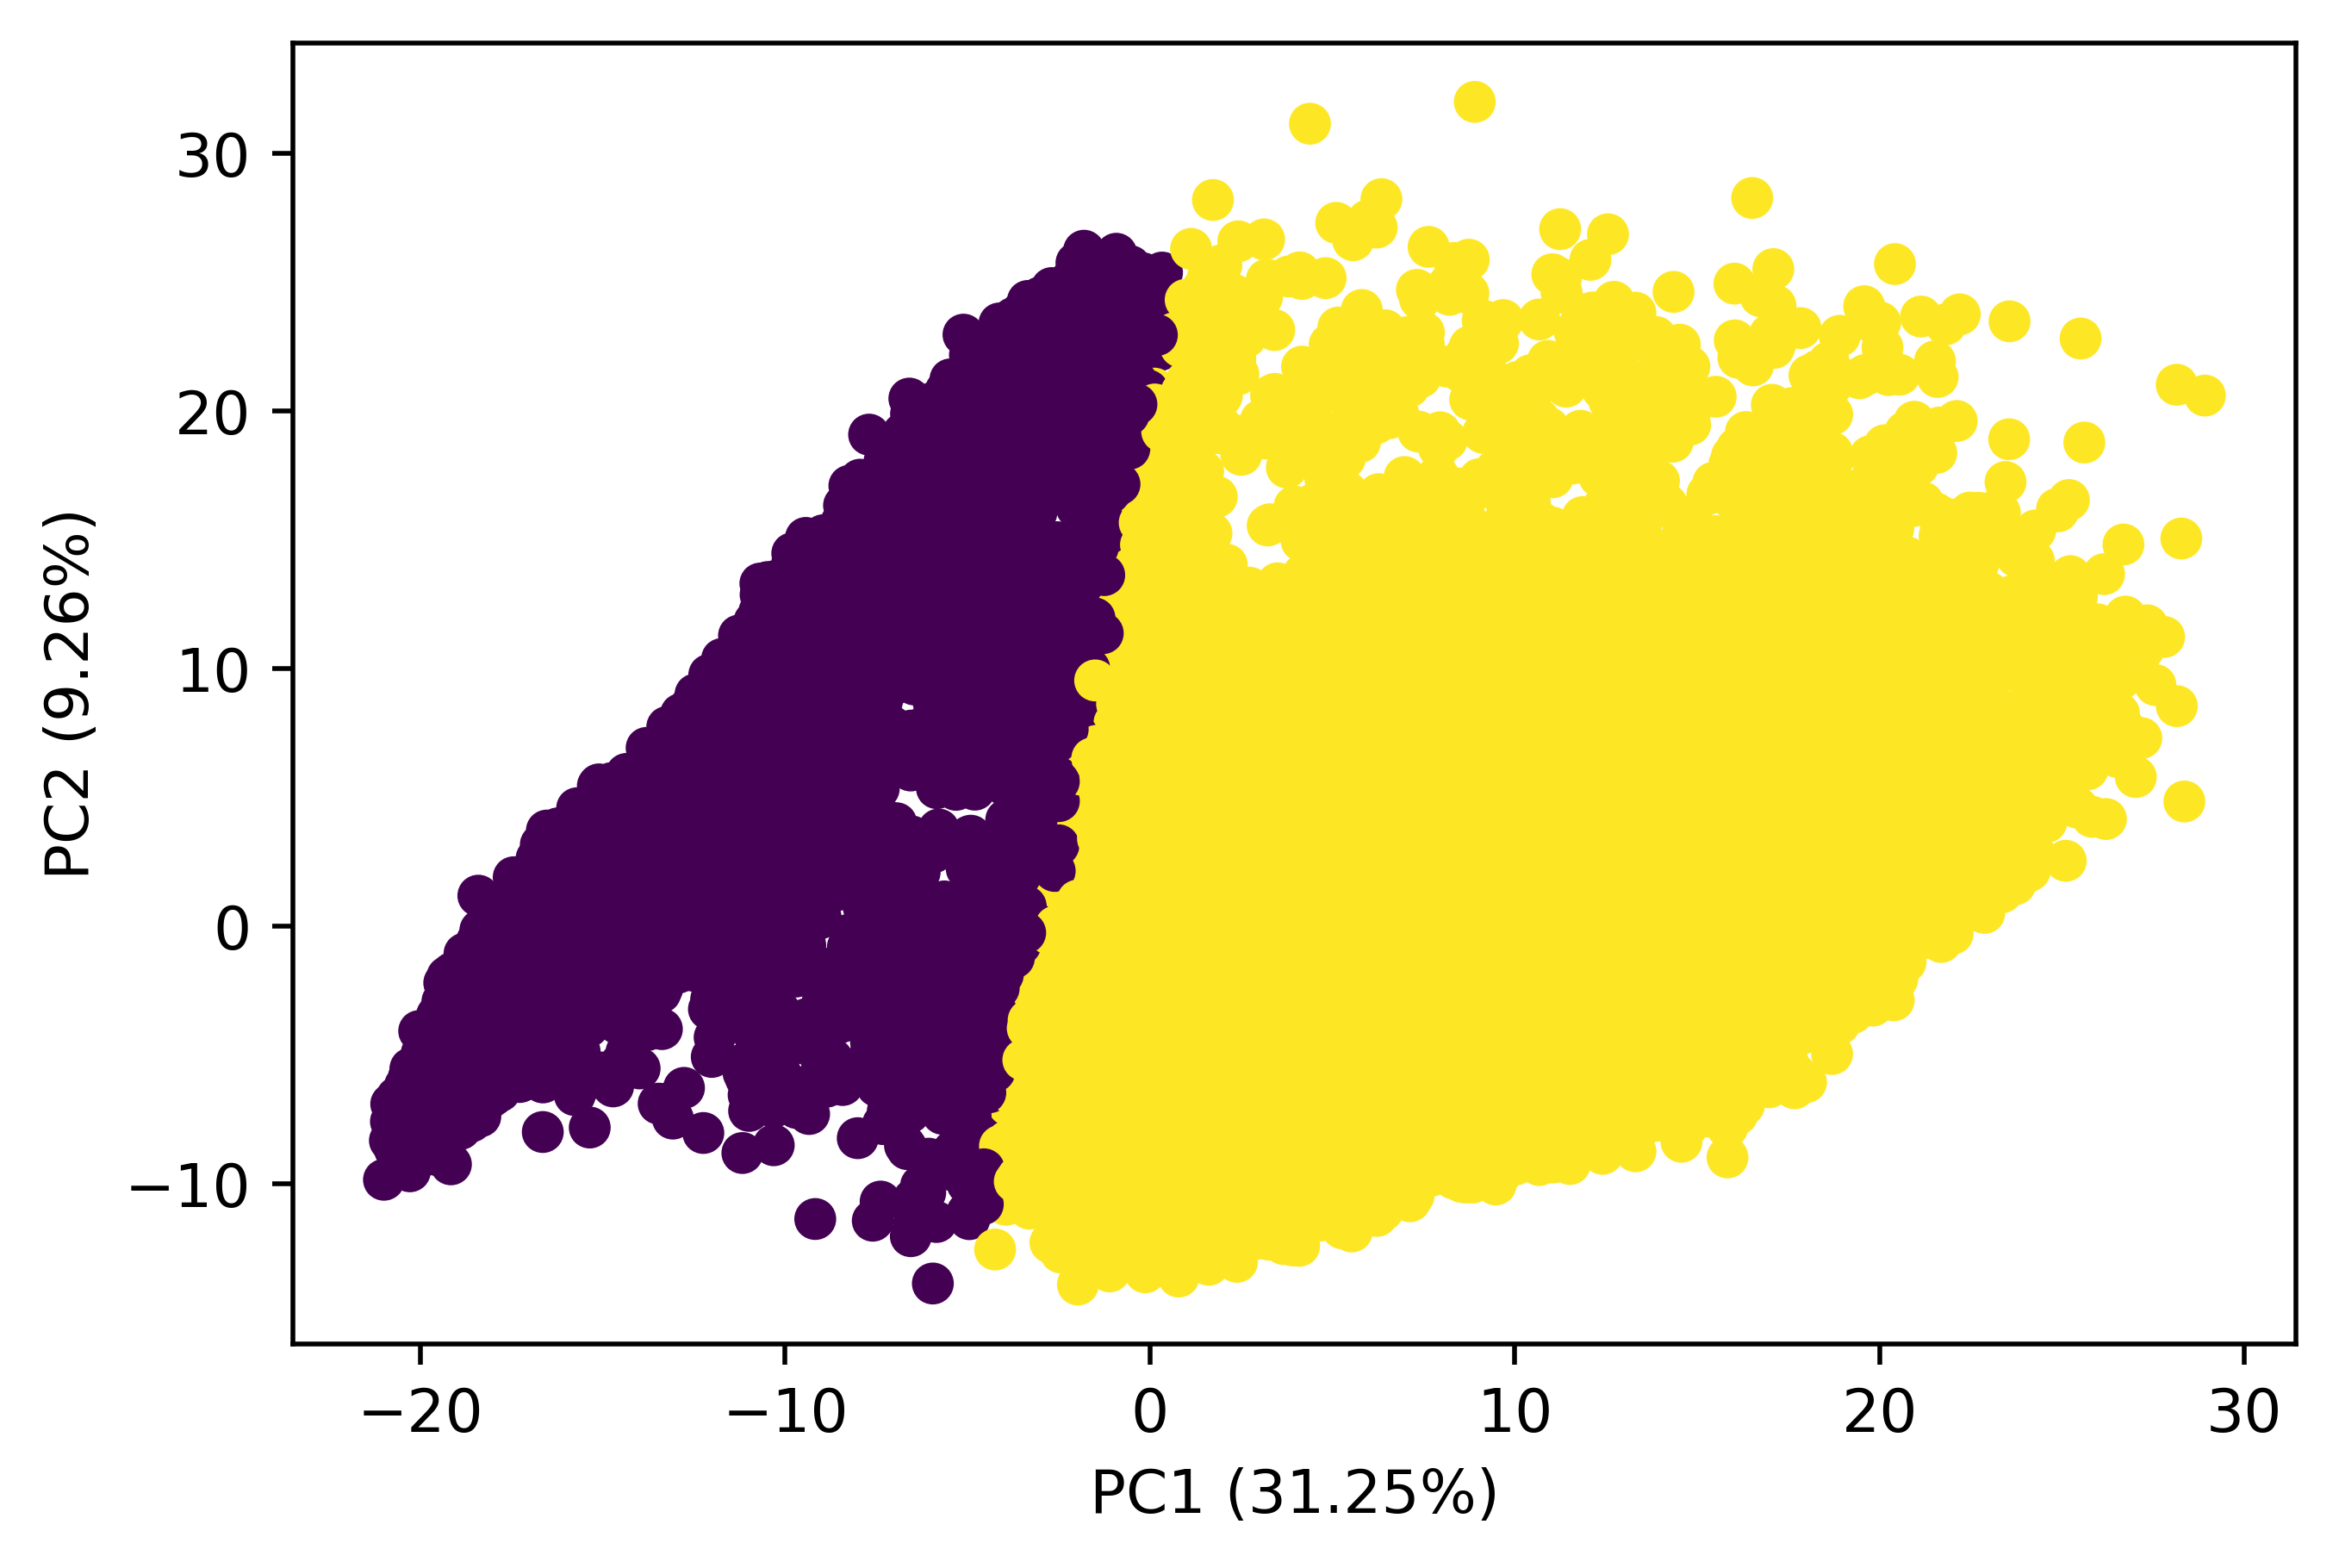

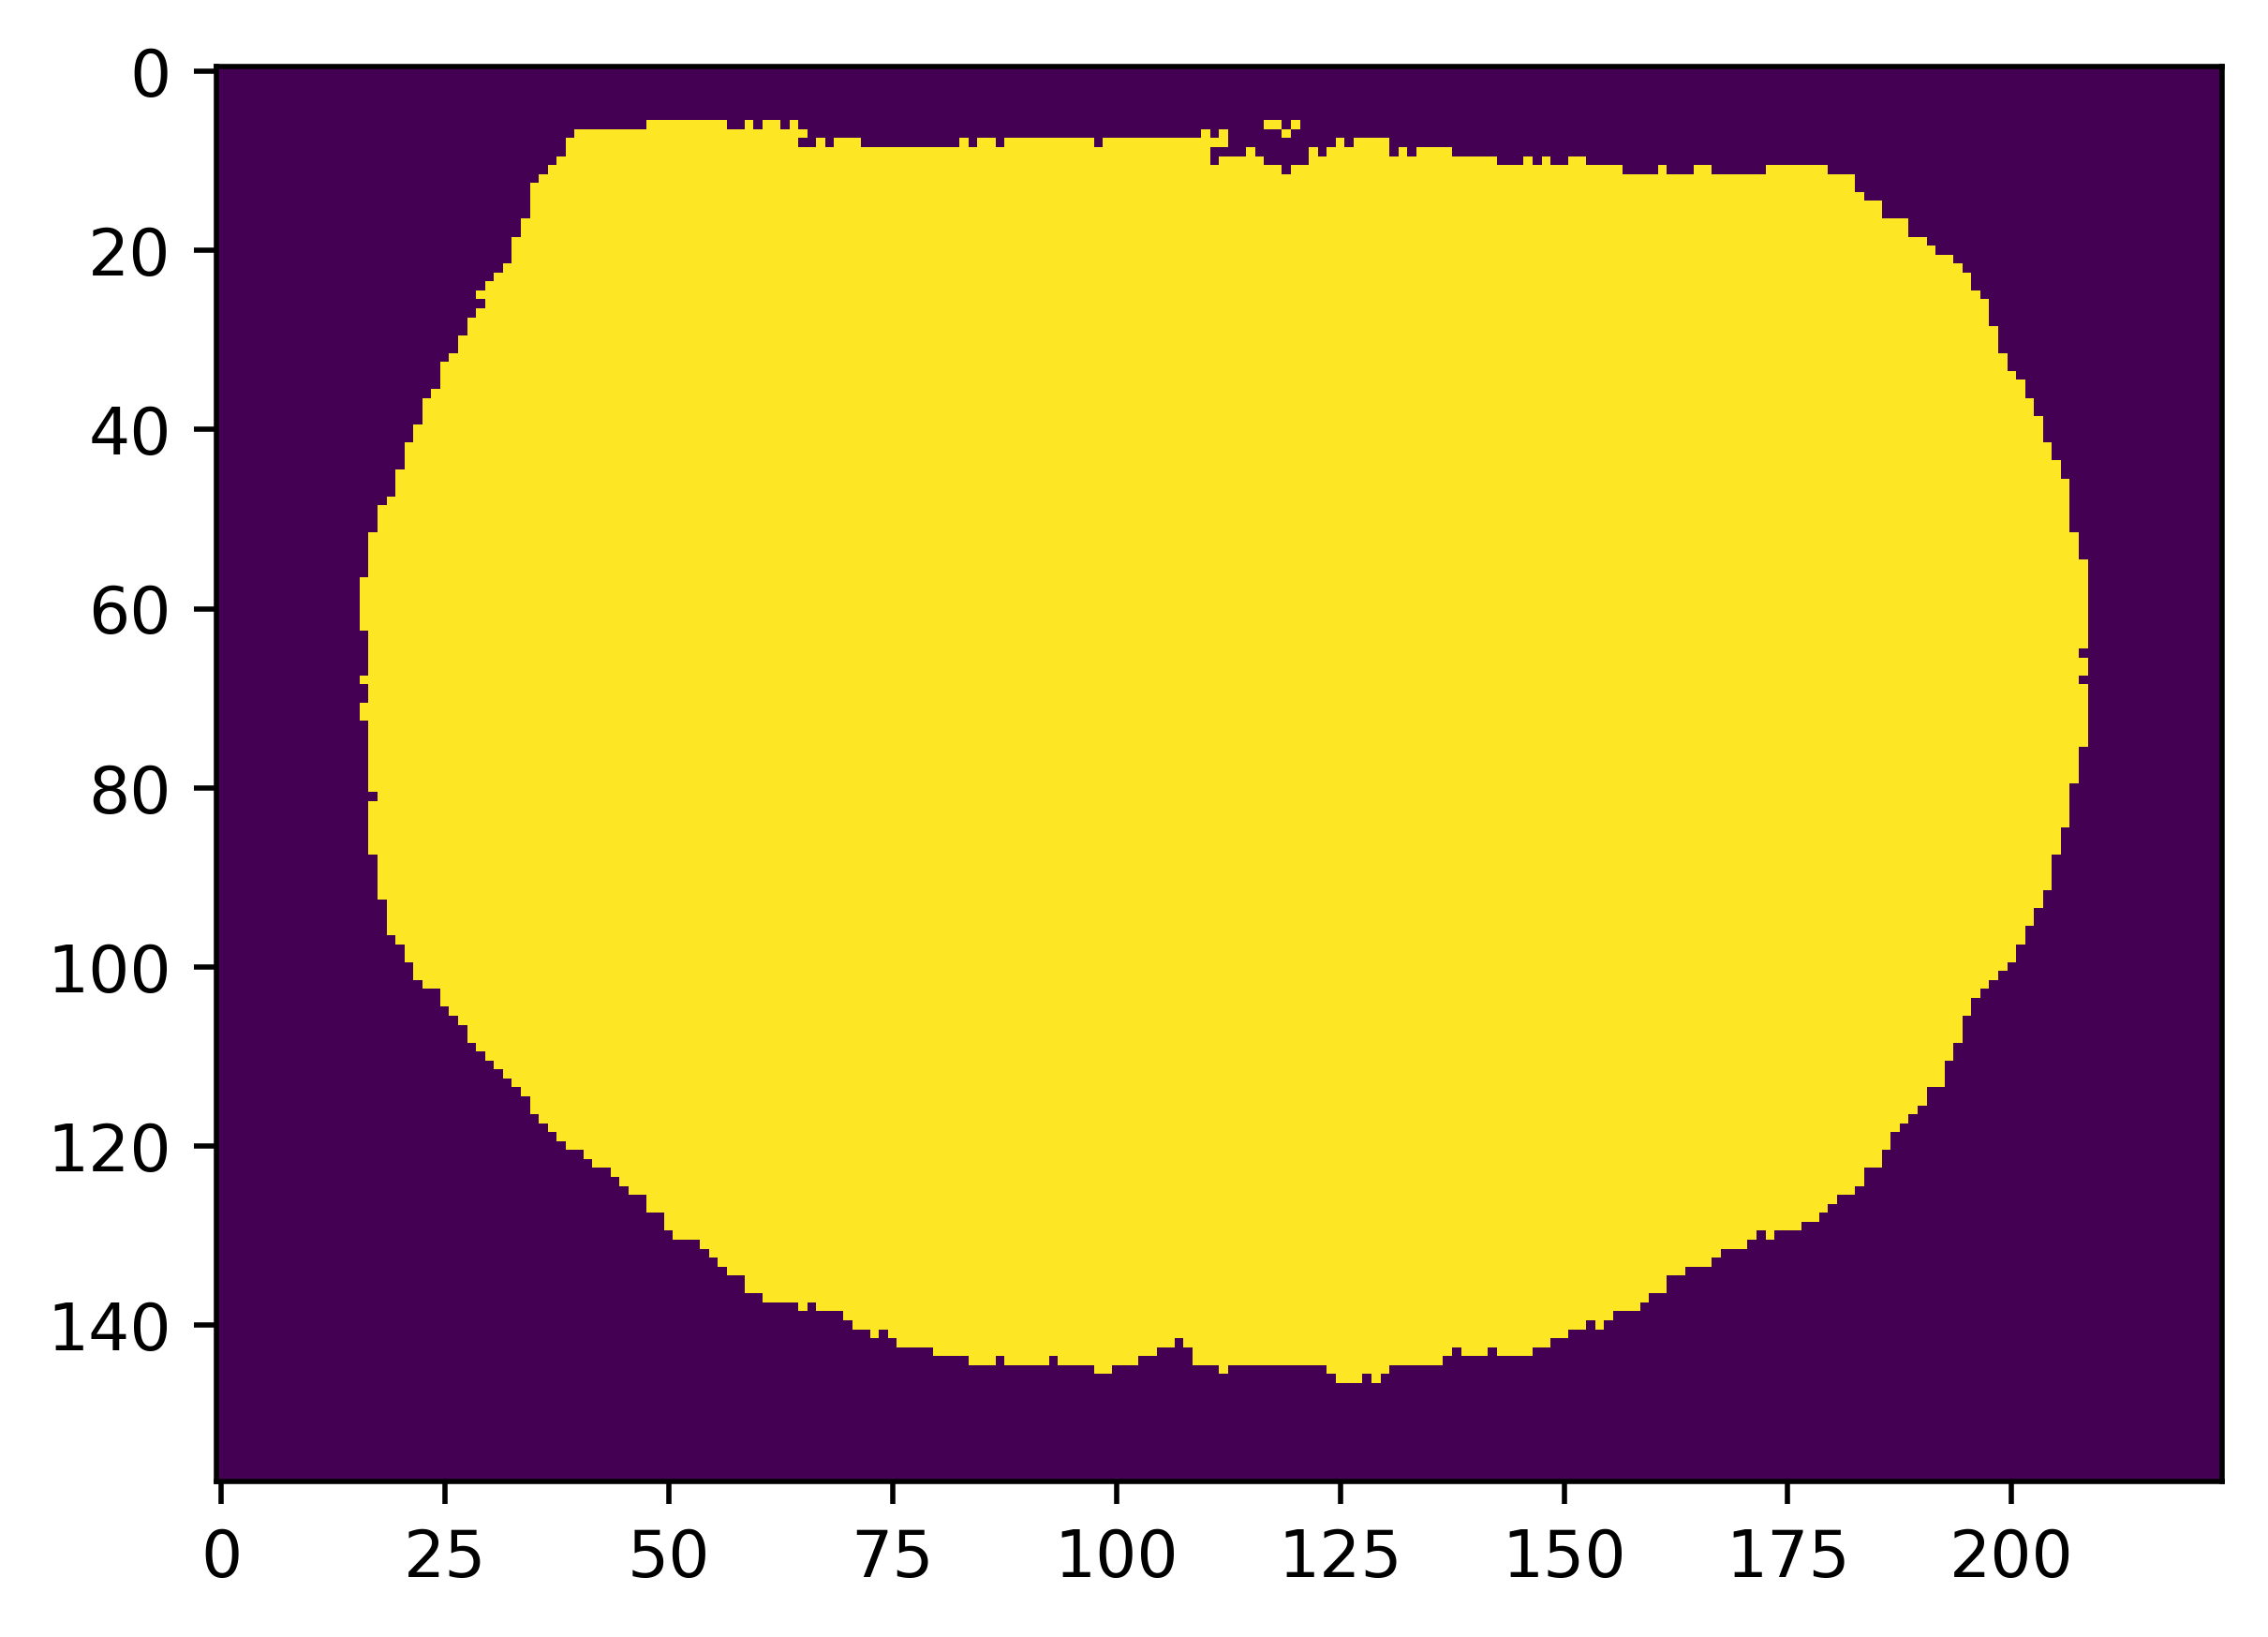

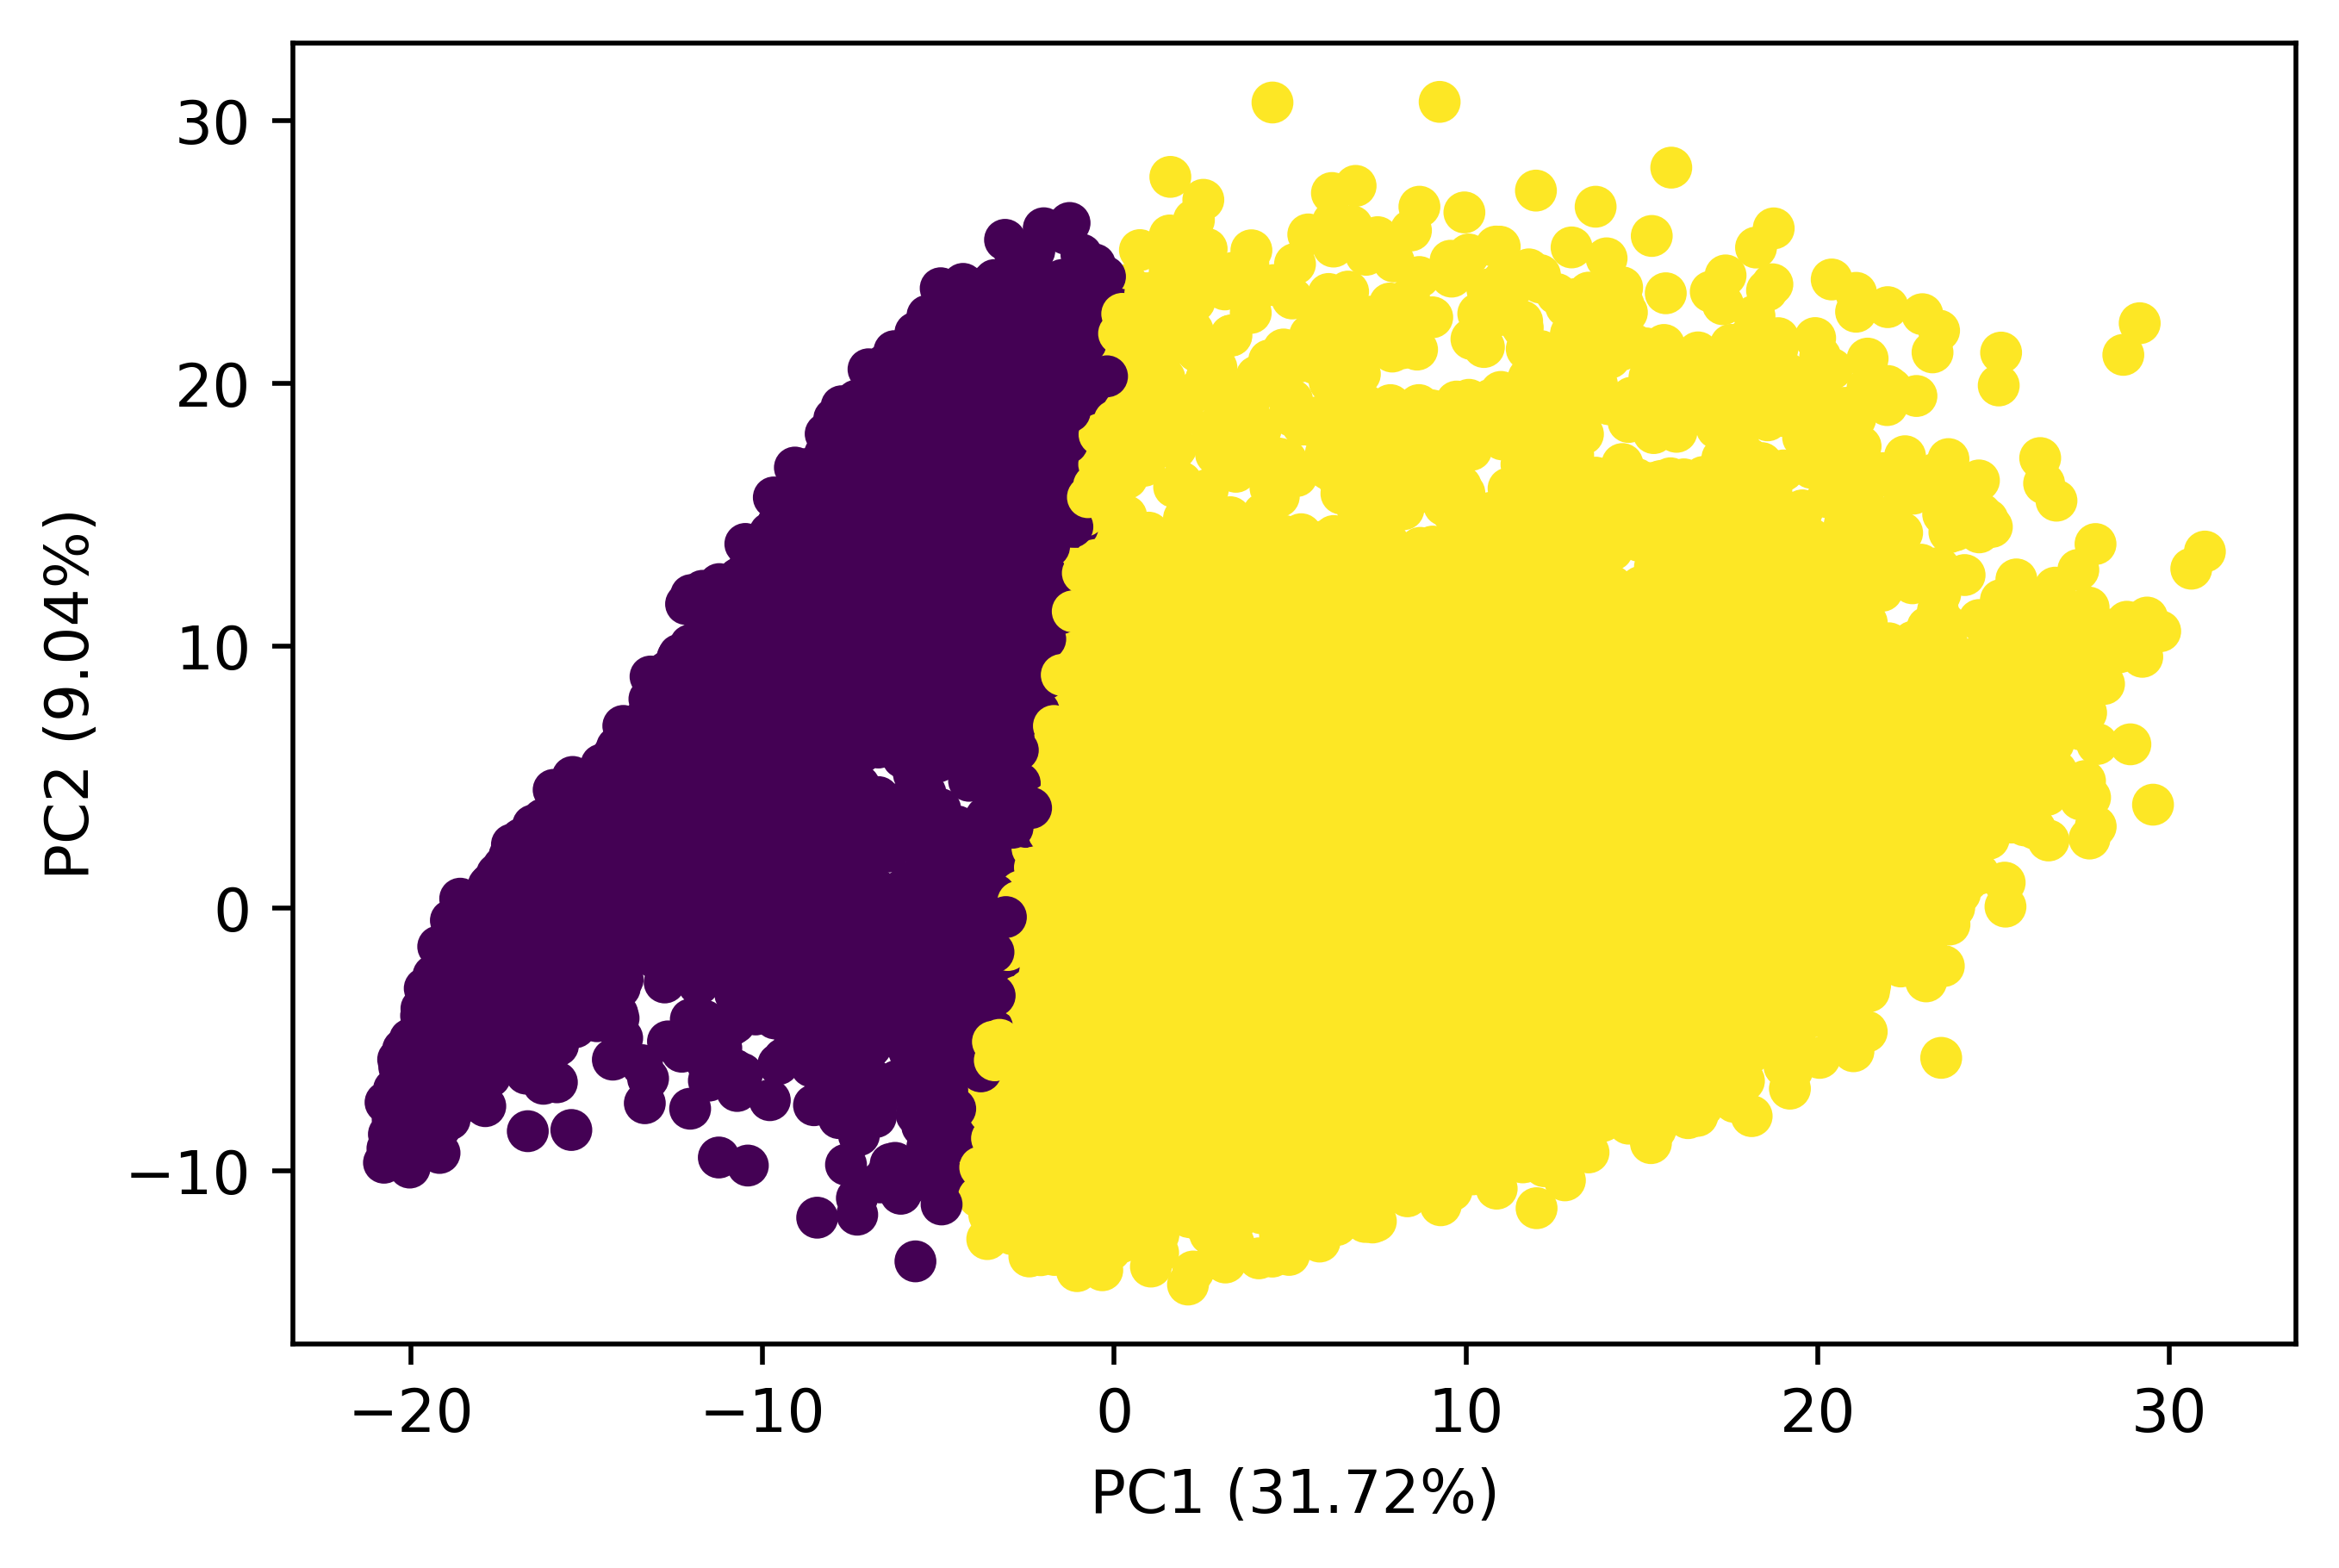

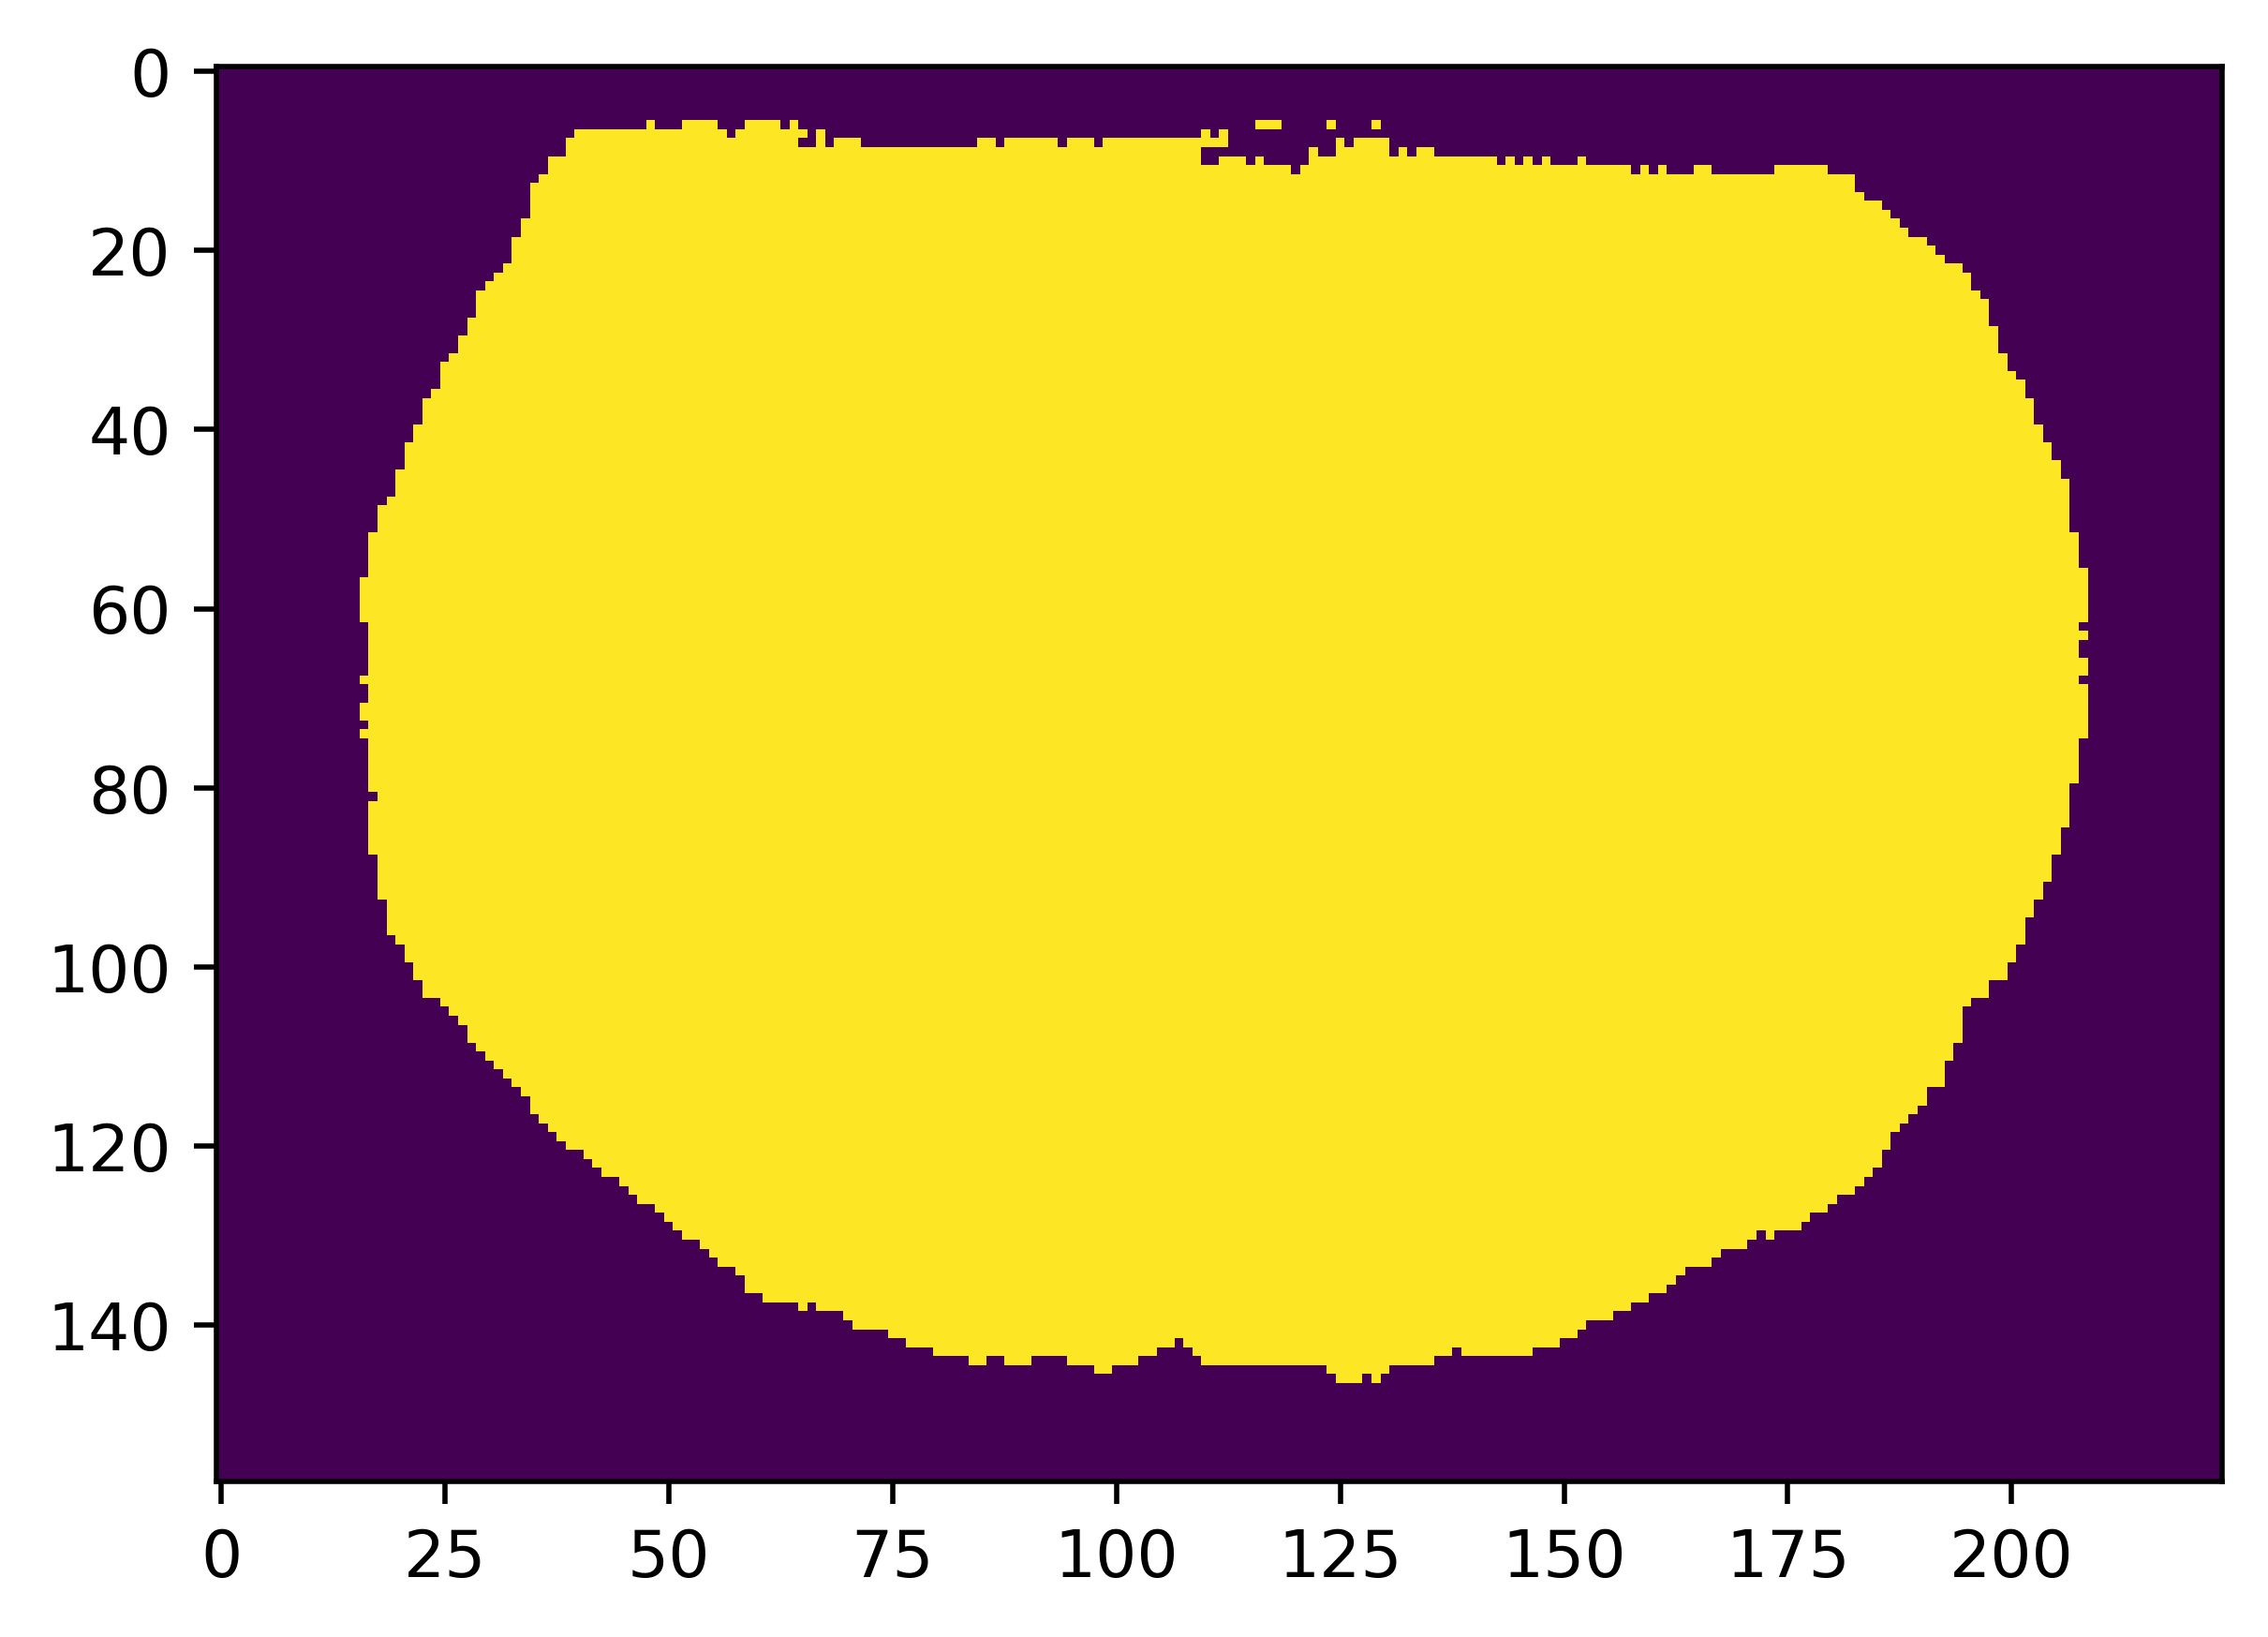

In [10]:
if __name__ == "__main__":
    msis = []
    for file,label,bound,mzList in zip(fns,labels,boxBoundaries,mzLists):
        tmp = []
        for mzs in mzList:
            msi = SIMSIToolBox.MSIData(mzs,ppm=ppm,numCores = numCores,intensityCutoff=intensityCutoff)
            msi.readimzML(inpath+file)
            msi.segmentImage(method="K_means")
            plt.figure()
            plt.imshow(msi.imageBoundary)
            tmp.append(msi)
        msis.append(tmp)

In [11]:
def plotMirror(spec1,spec2,ppm):
    spec1Mzs = list(spec1.keys())
    spec1Mzs.sort()
    spec2Mzs = list(spec2.keys())
    spec2Mzs.sort()
    spec1Colors = []
    spec2Colors = []
    for mz in spec1Mzs:
        mz2 = SIMSIToolBox.take_closest(spec2Mzs,mz)
        if np.abs(mz-mz2)/mz * 1e6 < ppm:
            spec1Colors.append("green")
        else:
            spec1Colors.append("blue")
            
    for mz in spec2Mzs:
        mz2 = SIMSIToolBox.take_closest(spec1Mzs,mz)
        if np.abs(mz-mz2)/mz * 1e6 < ppm:
            spec2Colors.append("green")
        else:
            spec2Colors.append("blue")
    
    max1 = 1#np.max(list(spec1.values()))
    minMz = np.min(spec1Mzs + spec2Mzs)
    maxMz = np.max(spec1Mzs + spec2Mzs)
    for mz,c in zip(spec1Mzs,spec1Colors):
        plt.plot([mz,mz],[0,np.log10(spec1[mz]/max1)],color=c,linewidth=0.3)
        
    max2 = 1#np.max(list(spec2.values()))
    for mz,c in zip(spec2Mzs,spec2Colors):
        plt.plot([mz,mz],[0,-1*np.log10(spec2[mz]/max2)],color=c,linewidth=0.3)
                 
    plt.plot([minMz,maxMz],[0,0],color="black")
    
def getMeanValueFromBox(arr,xmin,xmax,ymin,ymax):
    roi = []
    for x in range(xmin,xmax+1):
        for y in range(ymin,ymax+1):
            roi.append(arr[x,y])
    roi = np.array(roi)
    return np.mean(roi)

In [12]:
specs = []
for label,bound,mzList,msiList in zip(labels,boxBoundaries,mzLists,msis):
    tmp = []
    for mzs,msi,i in zip(mzList,msiList,["i","c"]):
        box = bound[i]
        spec = {}
        for x,mz in enumerate(mzs):
            val = getMeanValueFromBox(msi.data_tensor[x],*box[1],*box[0])
            spec[mz] = val
        tmp.append(spec)
    specs.append(tmp)

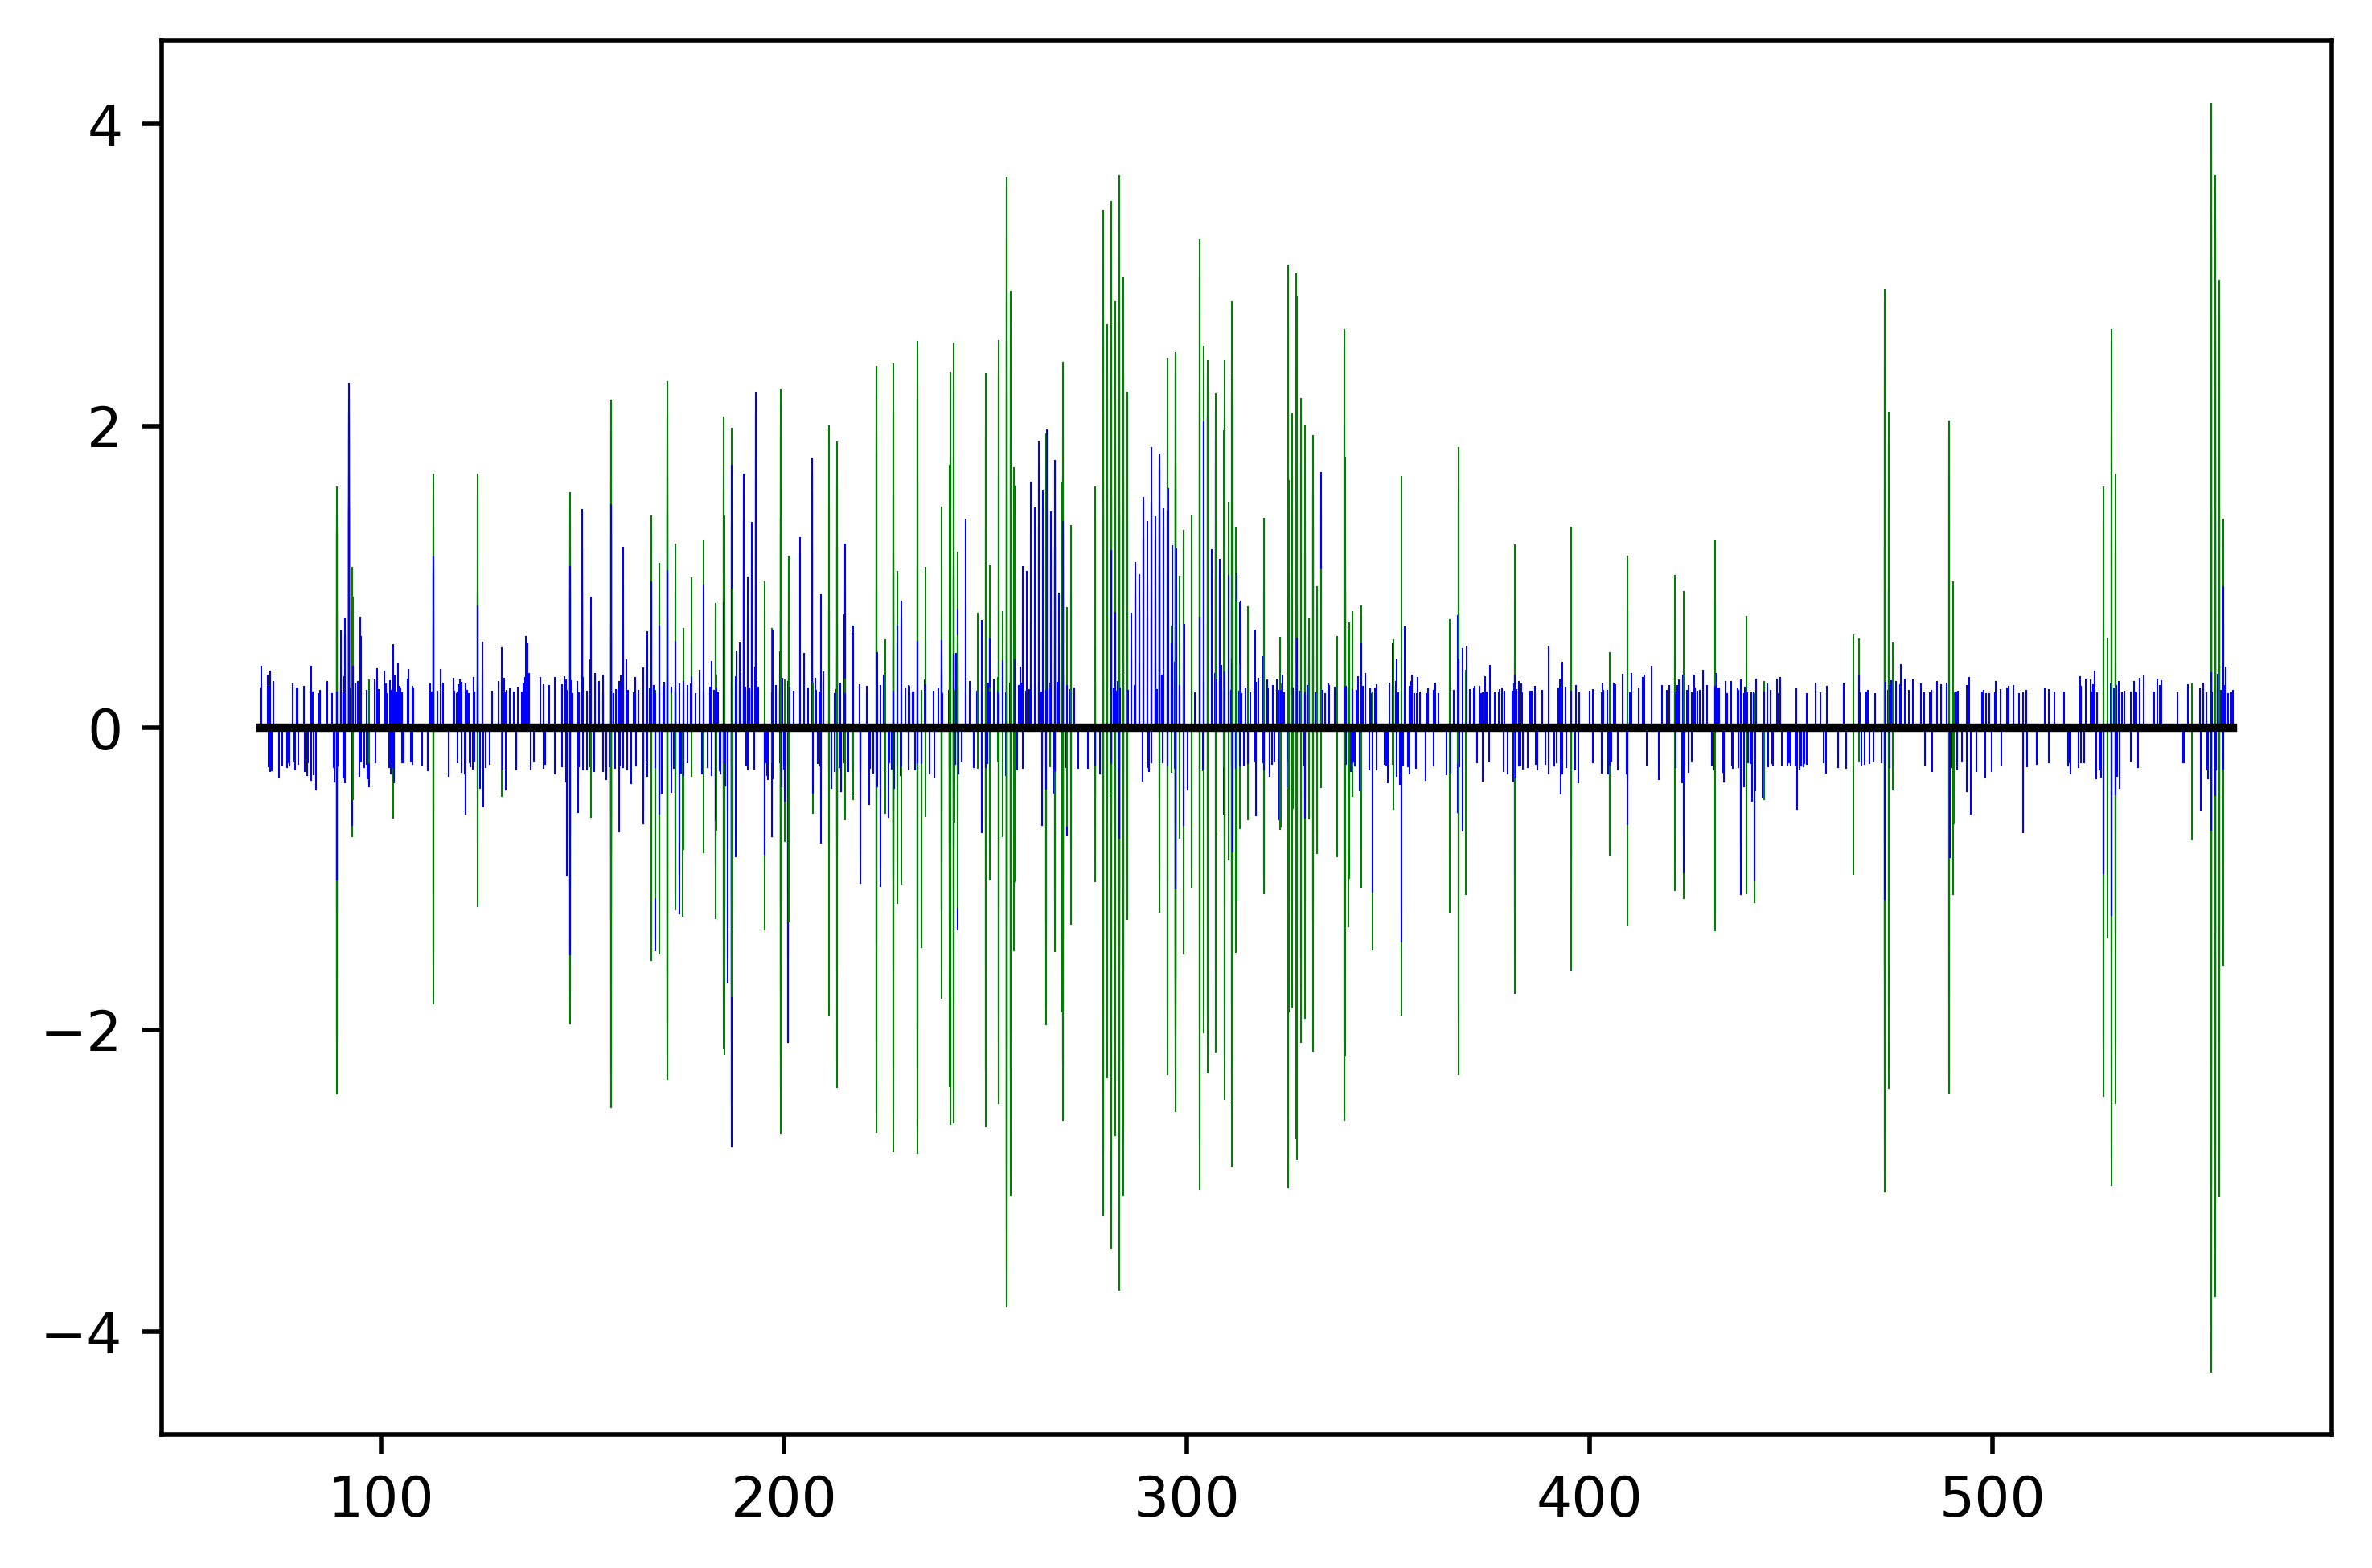

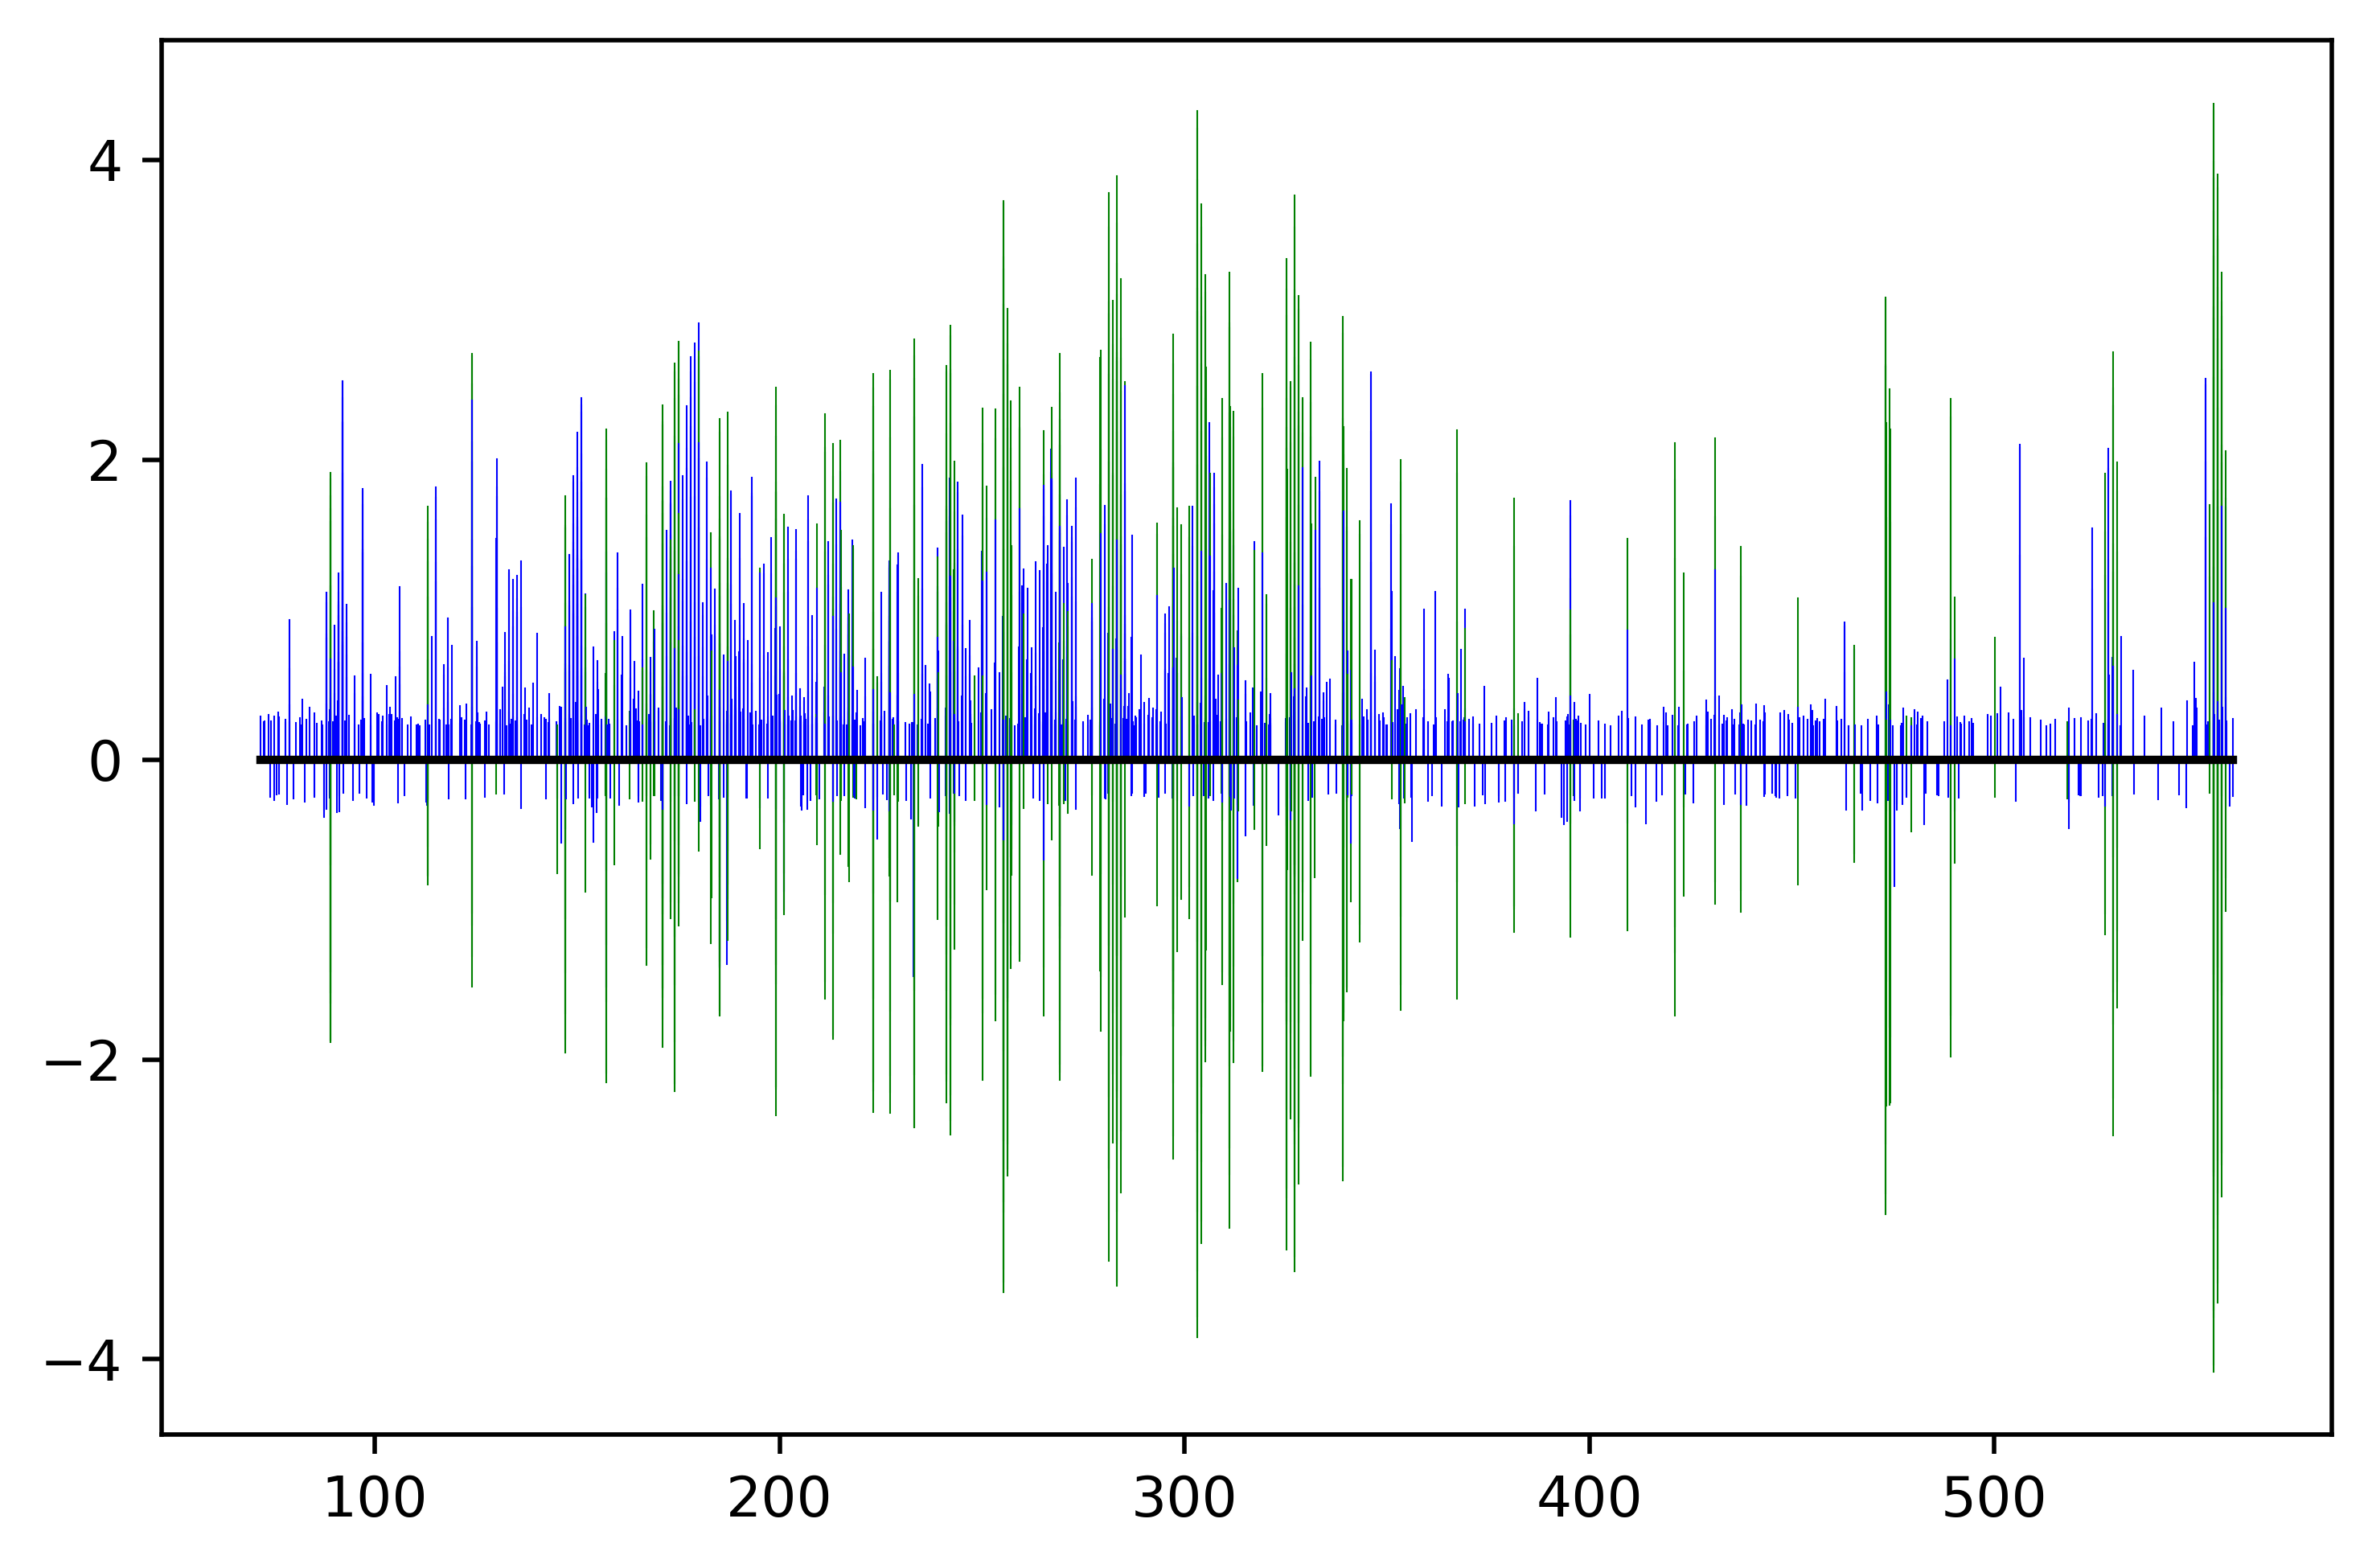

In [13]:
labels = ["i","c"]
for x in [0,1]:
    plt.figure()
    plotMirror(specs[0][x],specs[1][x],10)
    plt.tight_layout()
    plt.savefig("../figures_presentations/spectra_comparision_" + str(labels[x]) + ".png")

In [14]:
def addBox(xmin,xmax,ymin,ymax,color,image):
    image = deepcopy(image)
    image[xmin:xmax+1,ymin] = color
    image[xmin:xmax+1,ymax] = color
    image[xmin,ymin:ymax+1] = color
    image[xmax,ymin:ymax+1] = color
    return image

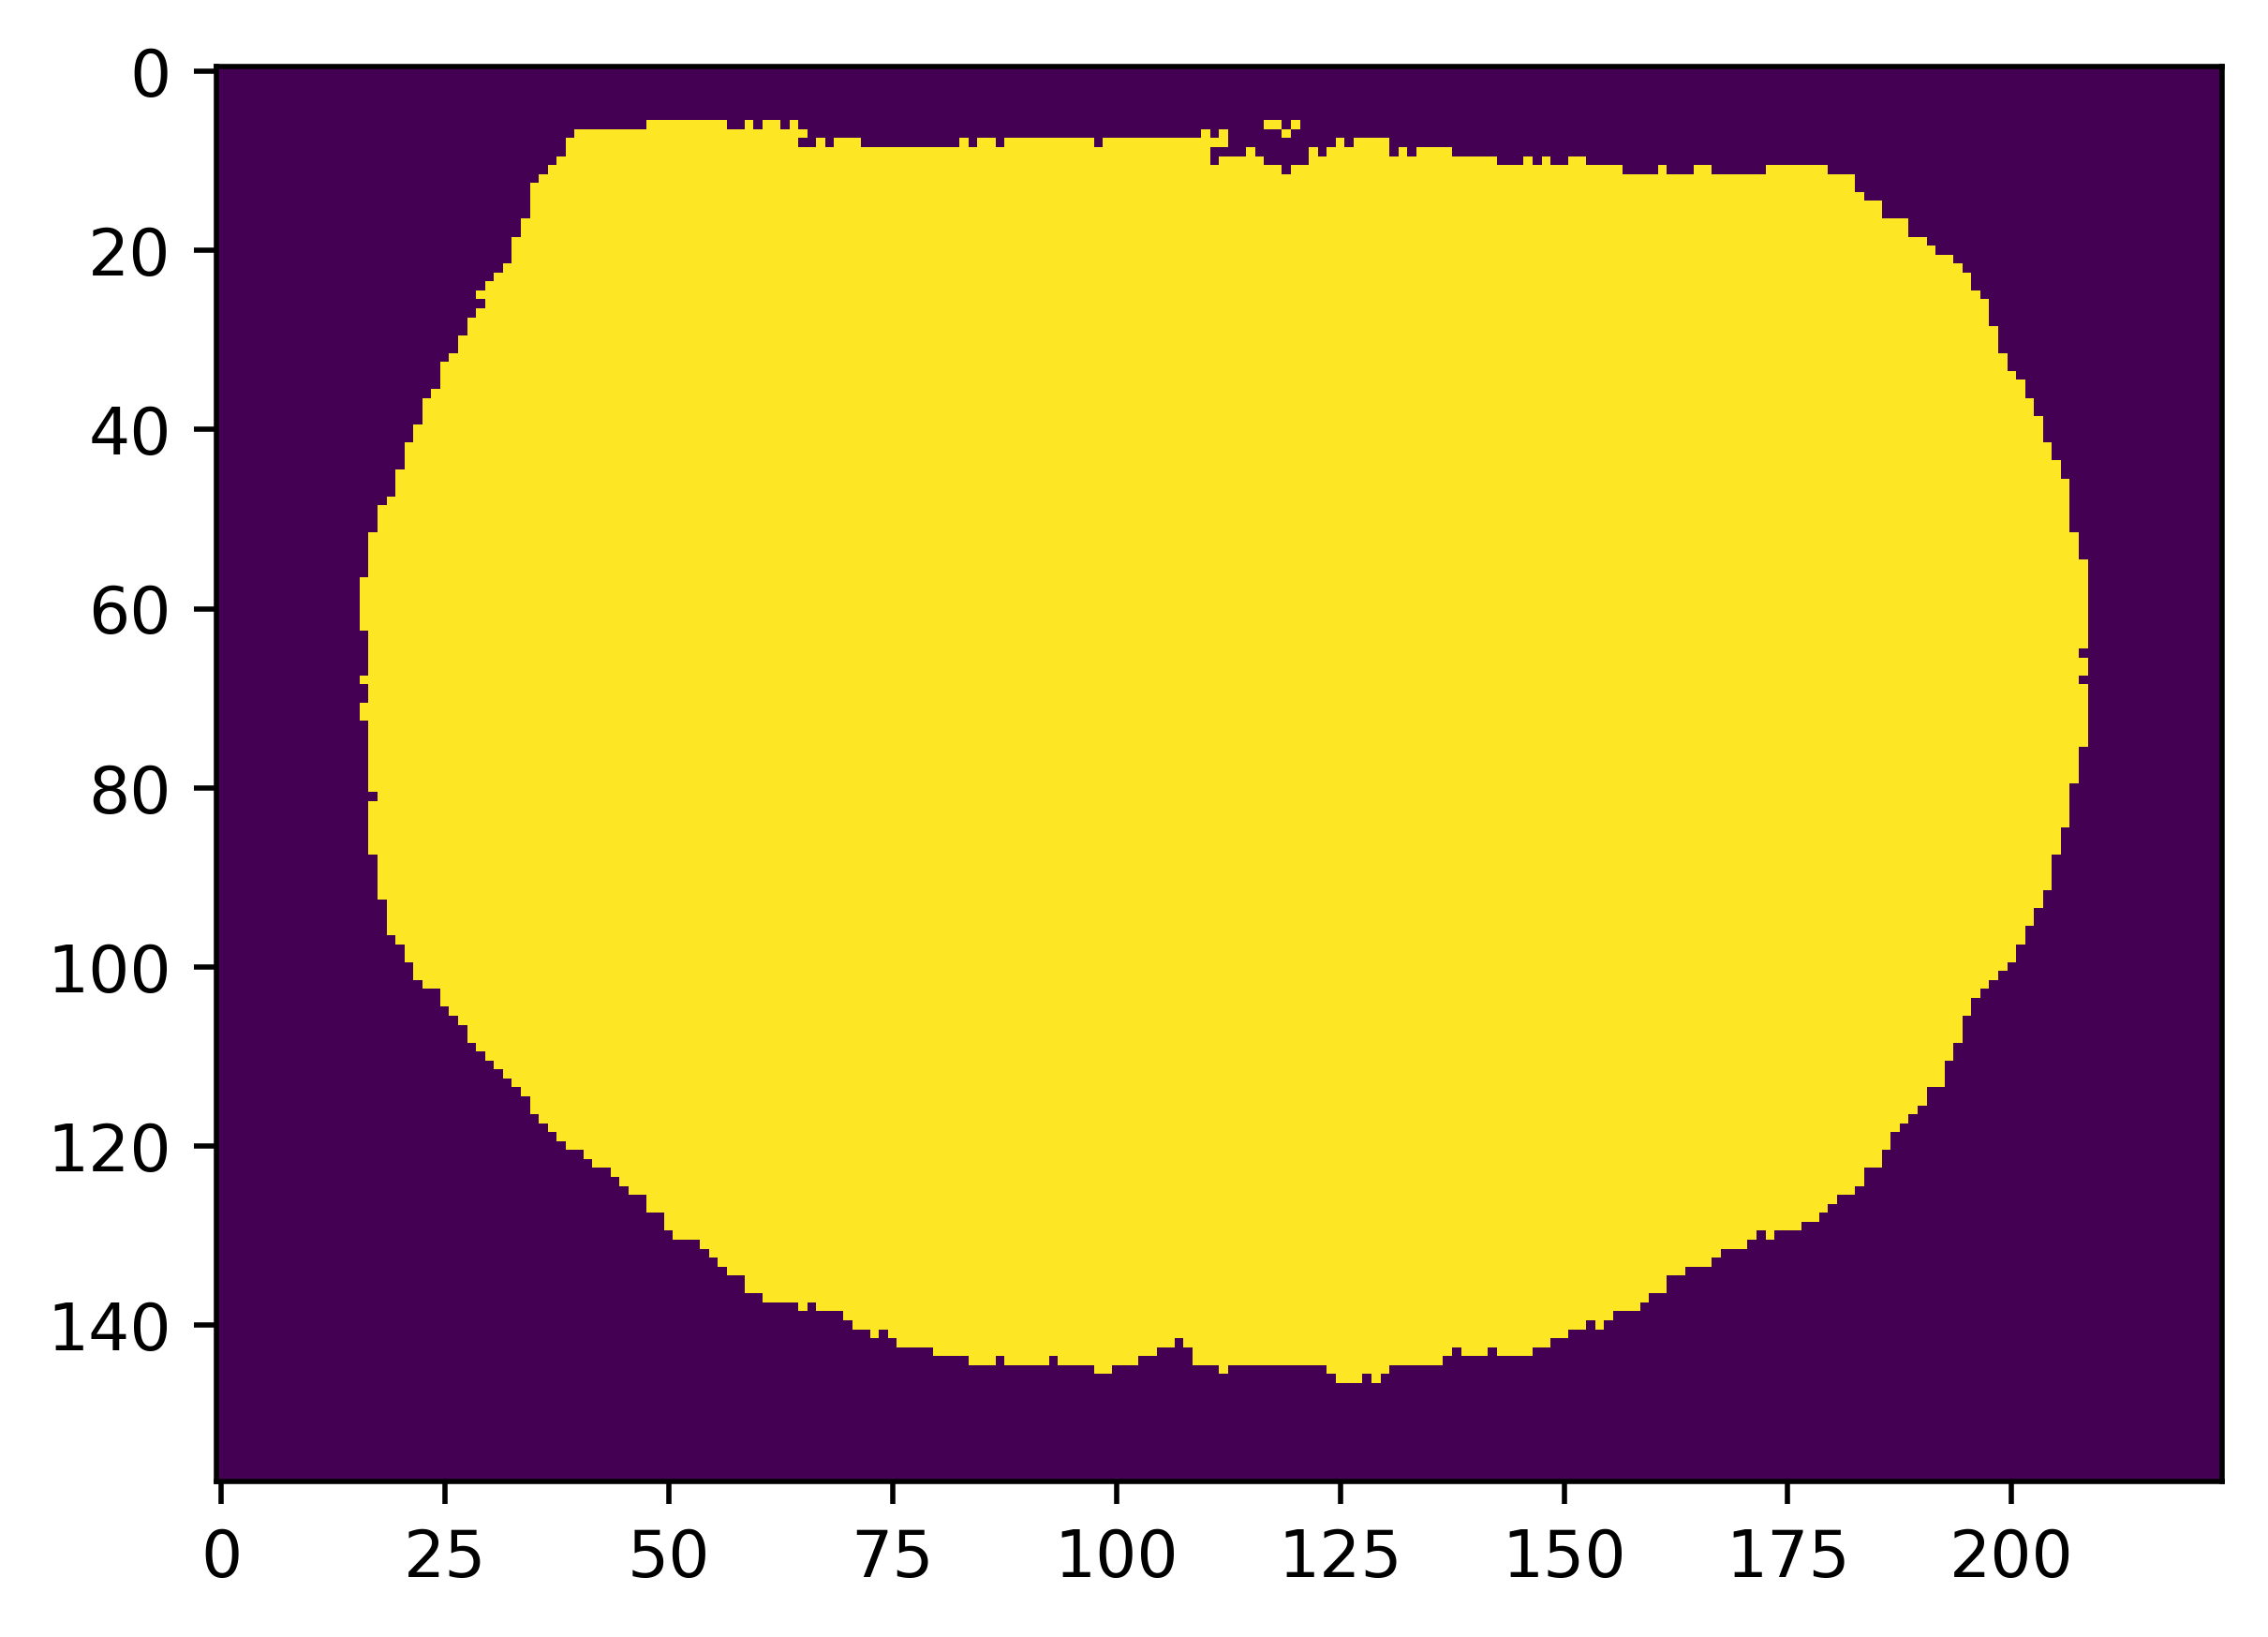

In [15]:
for msiList,fn,bounds in zip(msis,fns,boxBoundaries):
    msi = msiList[0]
    plt.imshow(msi.imageBoundary)
    ticImage = msi.tic_image
    maxLim = np.max(ticImage)
    norm = plt.Normalize(vmin=0, vmax=maxLim)
    norm = colormap(norm(ticImage))
    for row in range(norm.shape[0]):
        for col in range(norm.shape[1]):
            if msi.imageBoundary[row,col] < .5:
                norm[row,col,3] = 0
    
    box1 = bounds["i"]
    box2 = bounds["c"]

    norm = addBox(*box1[1],*box1[0],(1.0,0,0,1.0),norm)
    norm = addBox(*box2[1],*box2[0],(1.0,0,0,1.0),norm)

    plt.imsave("../figures_presentations/" + fn[3:].replace(".imzML","_ticImage.png"),norm)

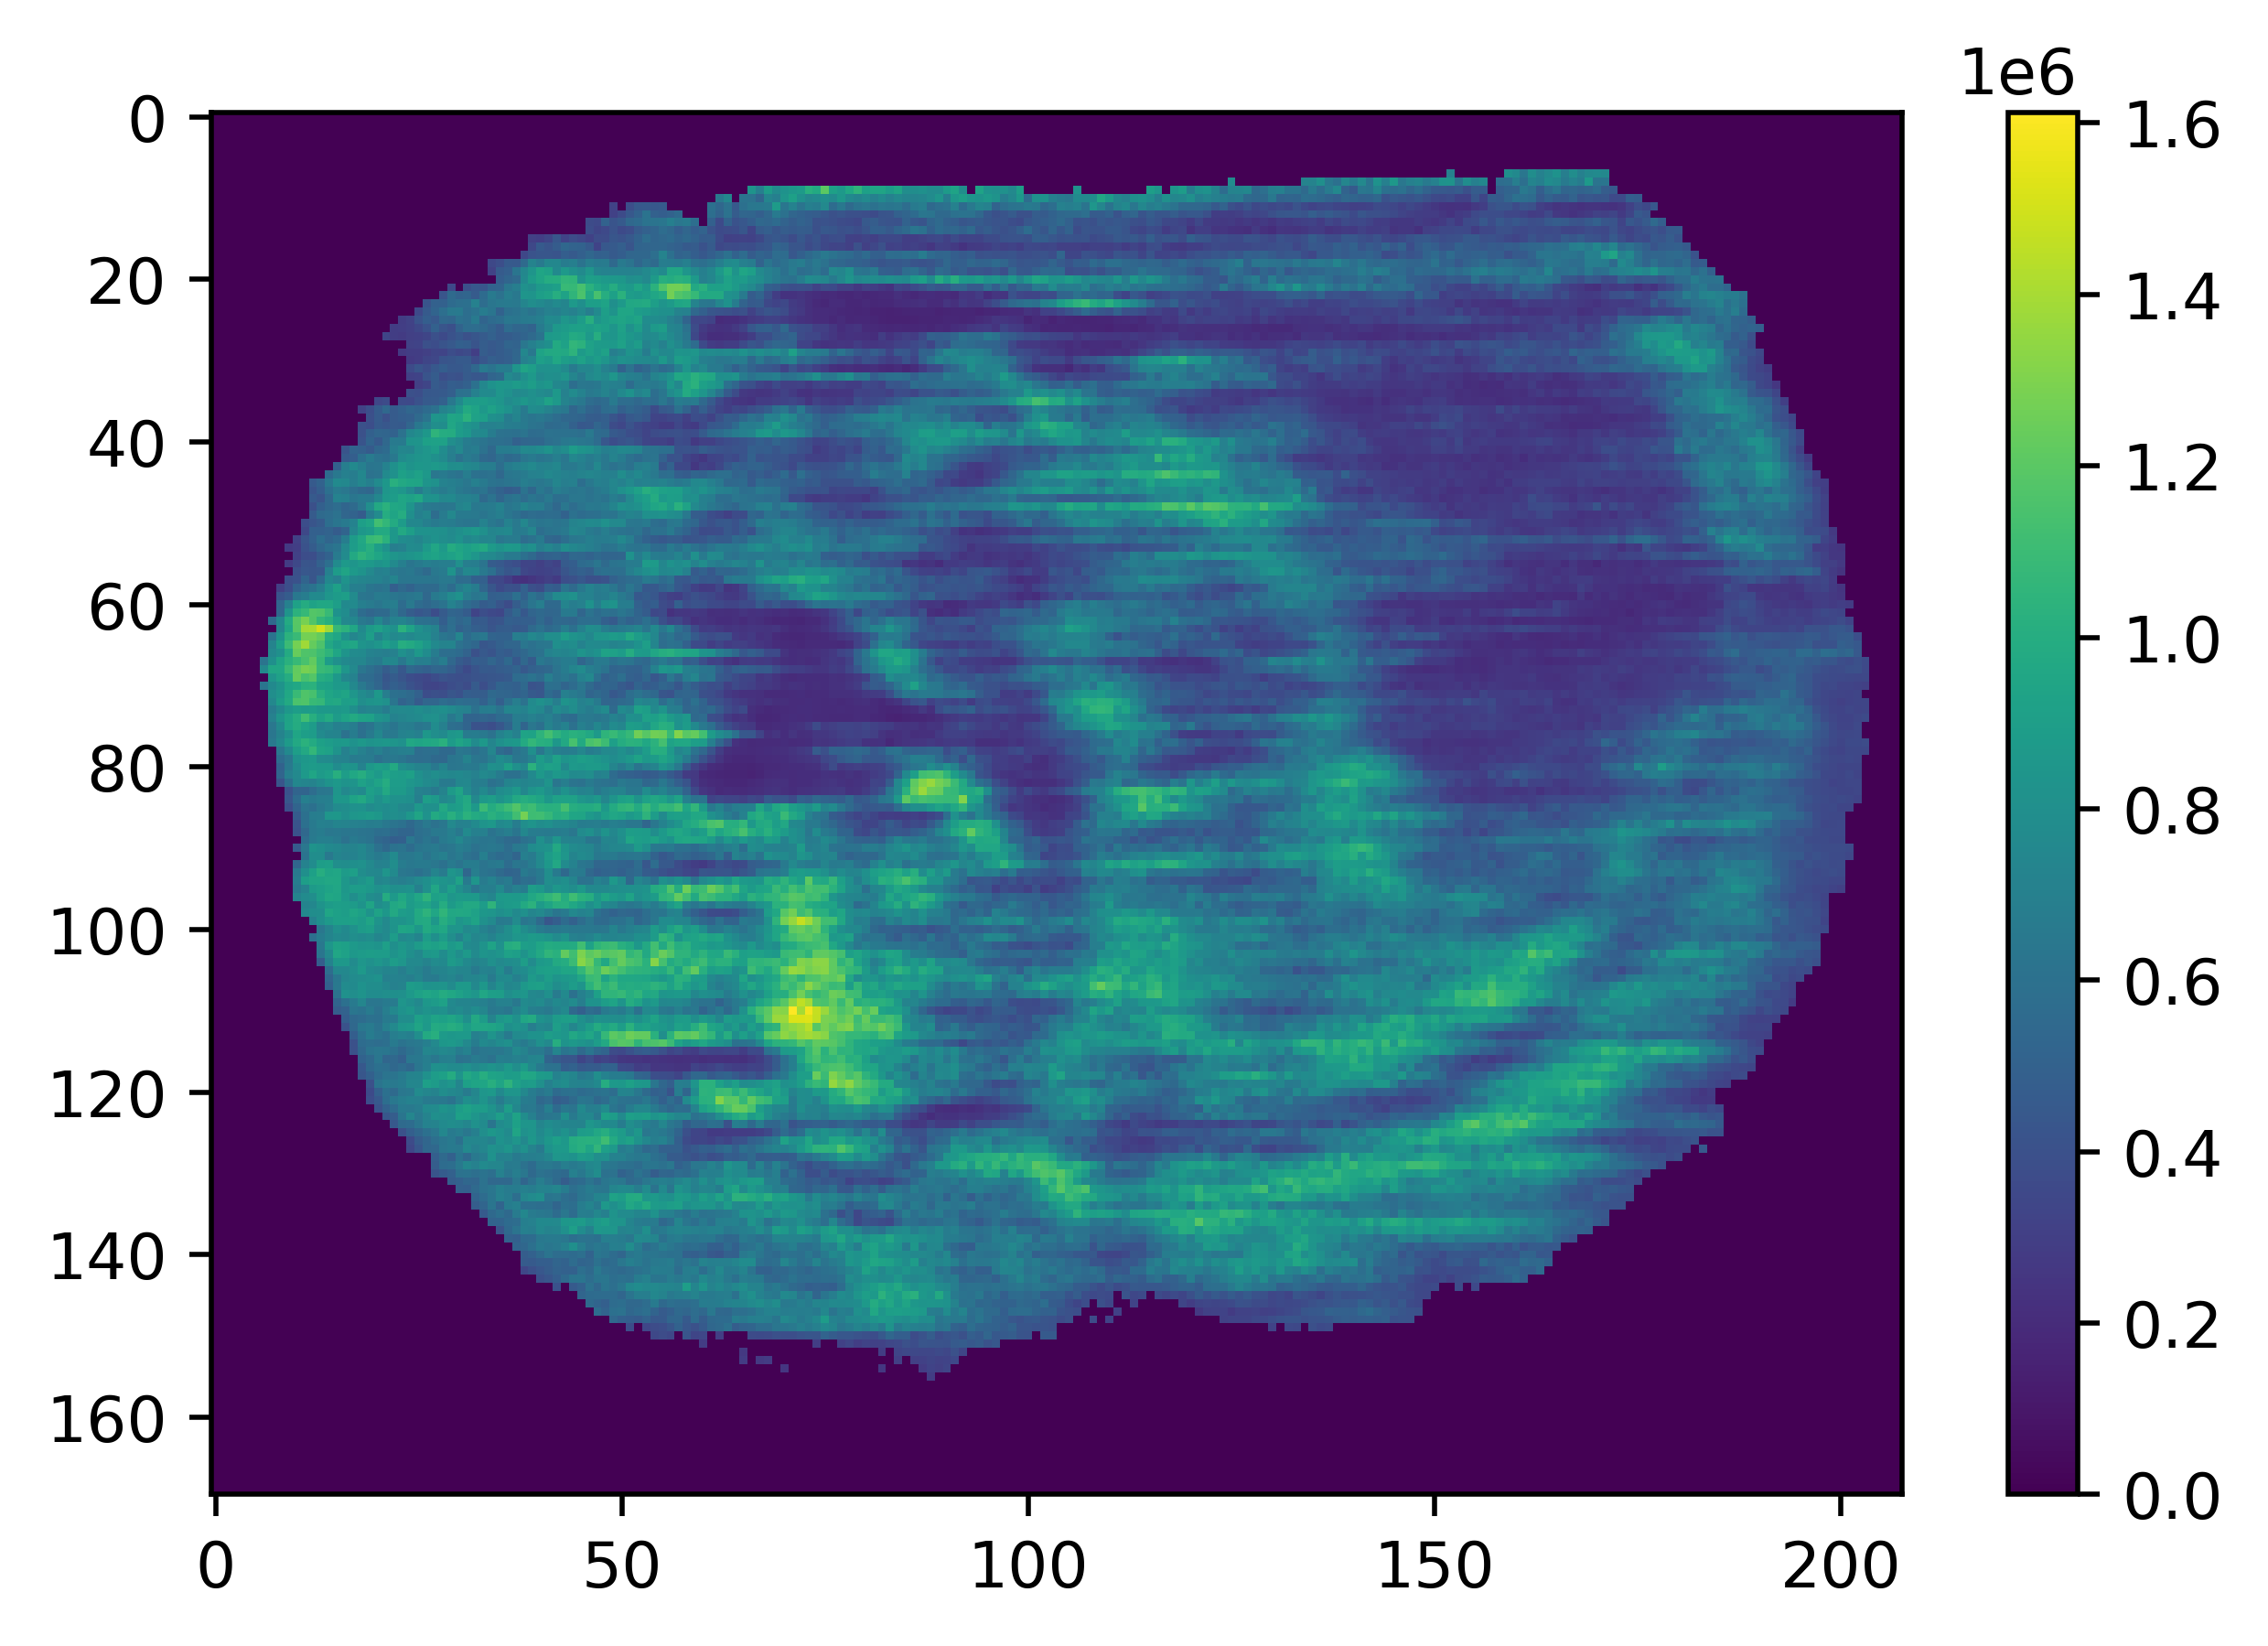

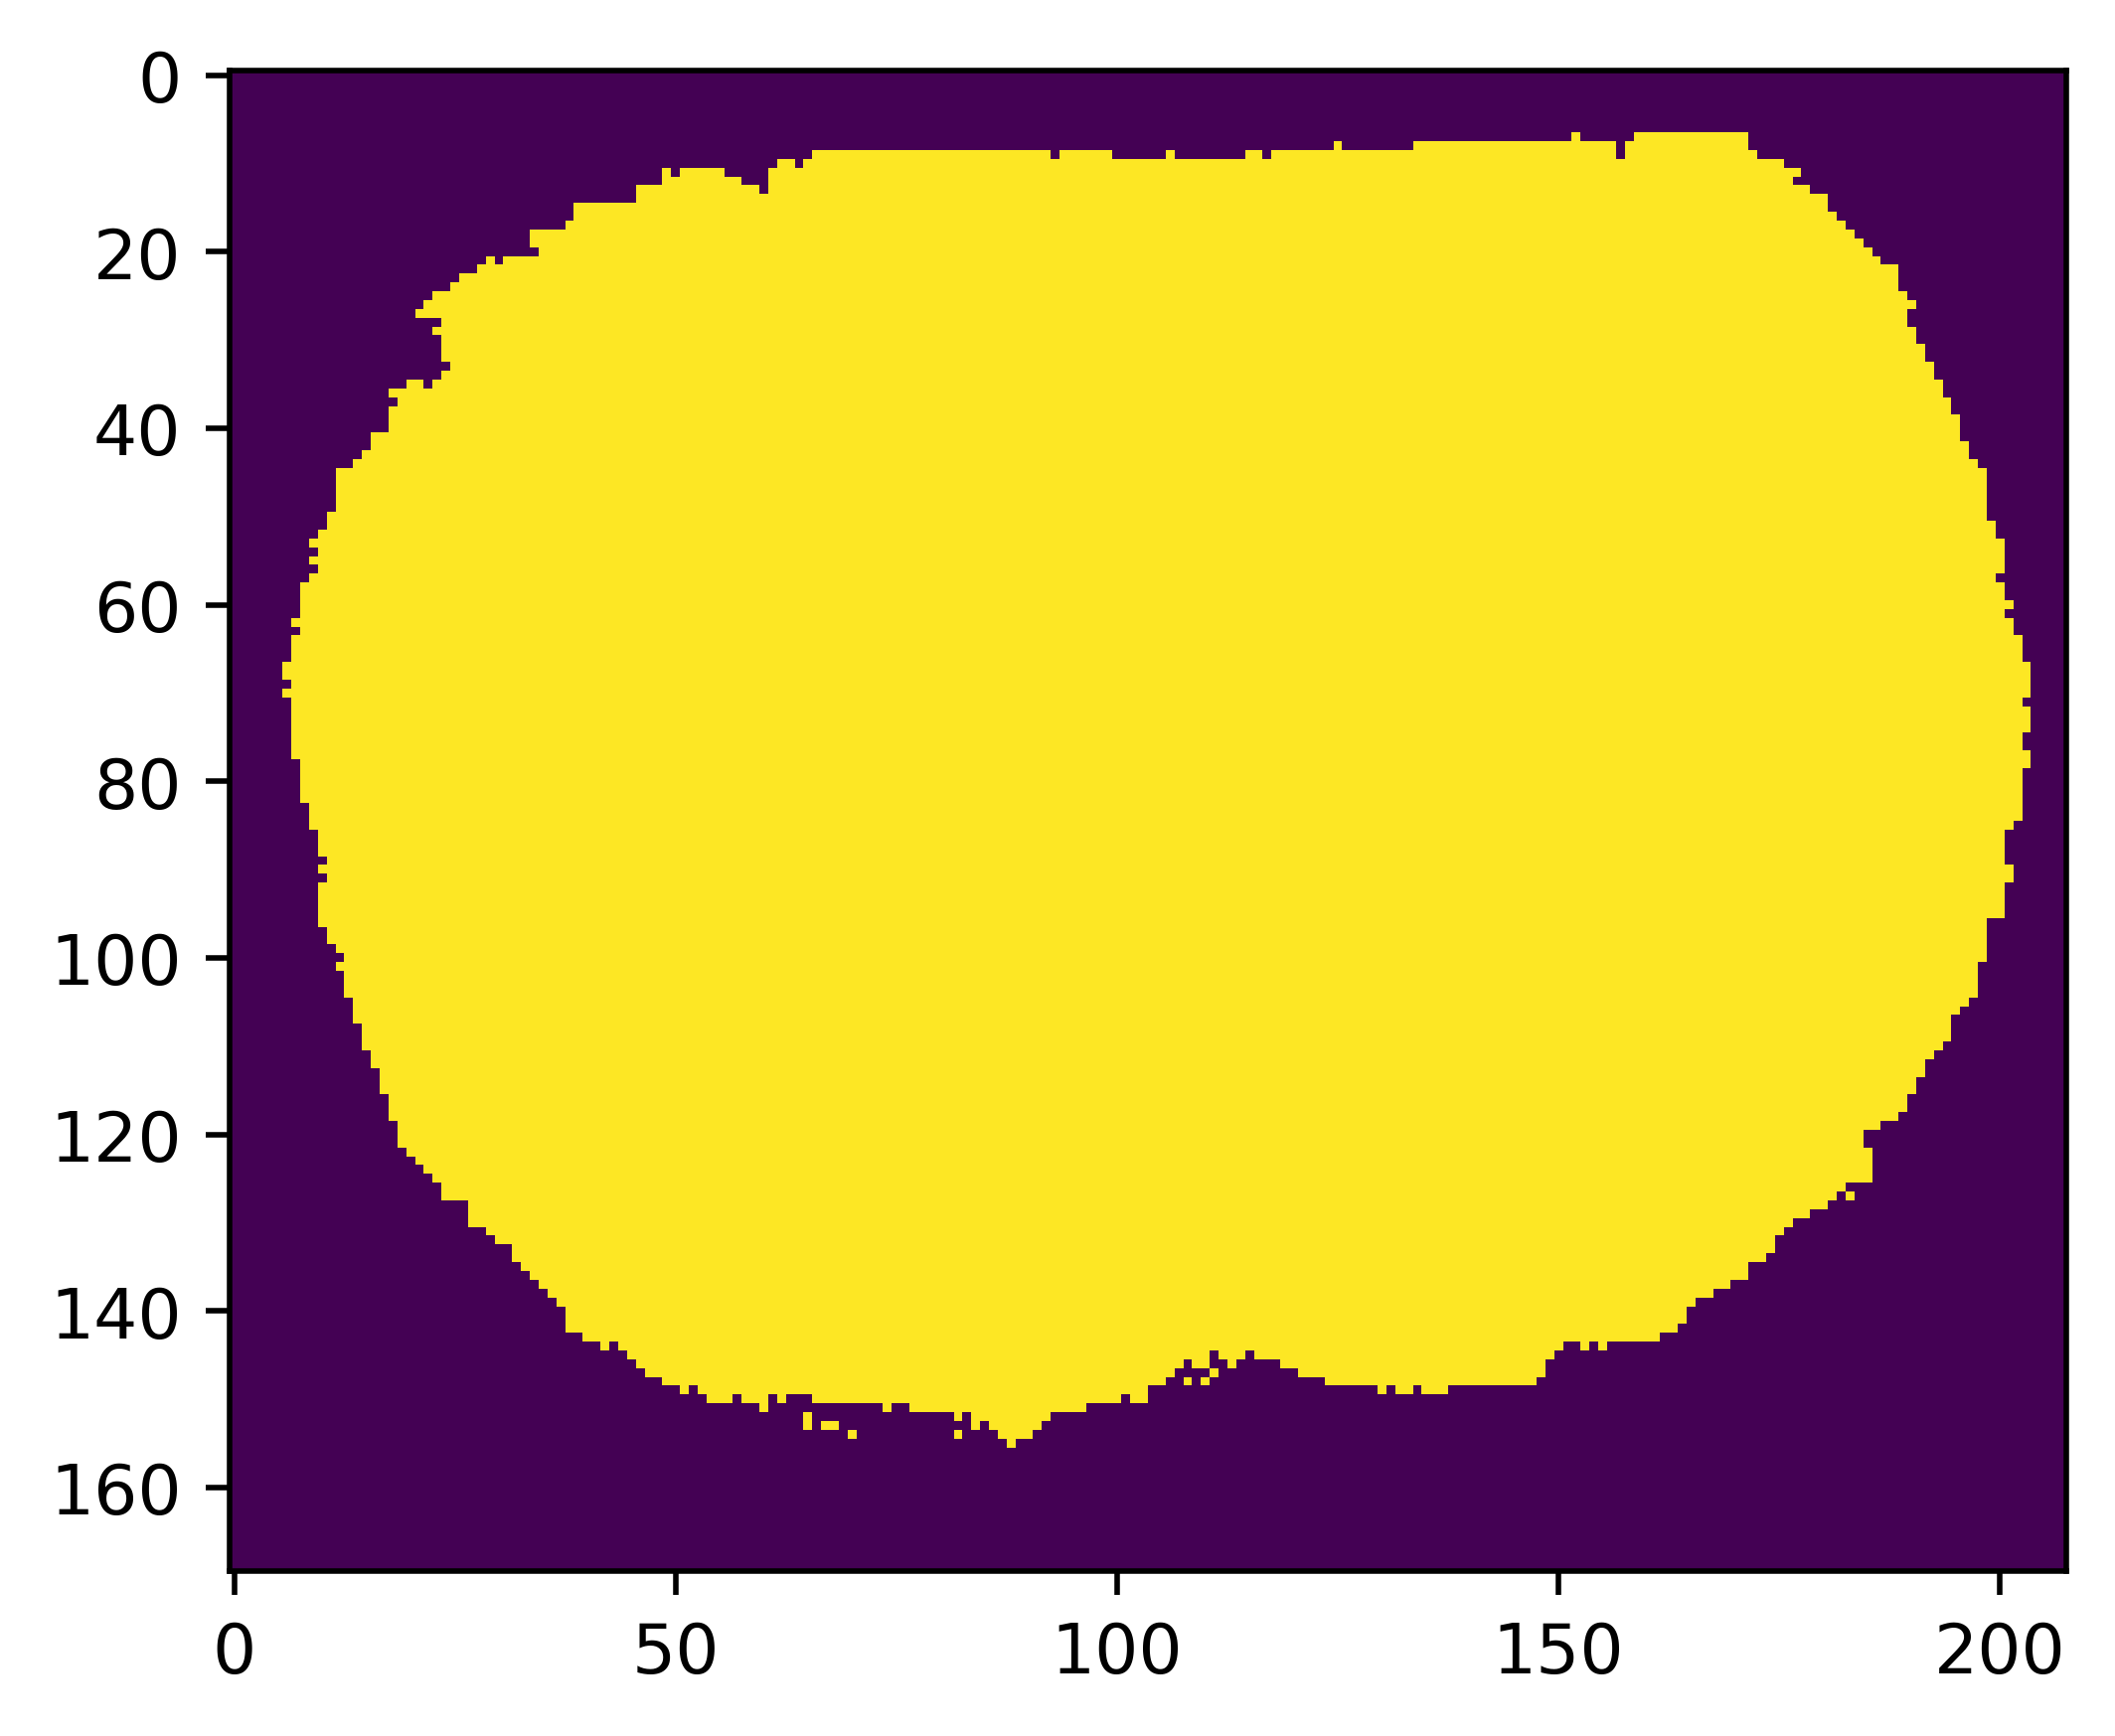

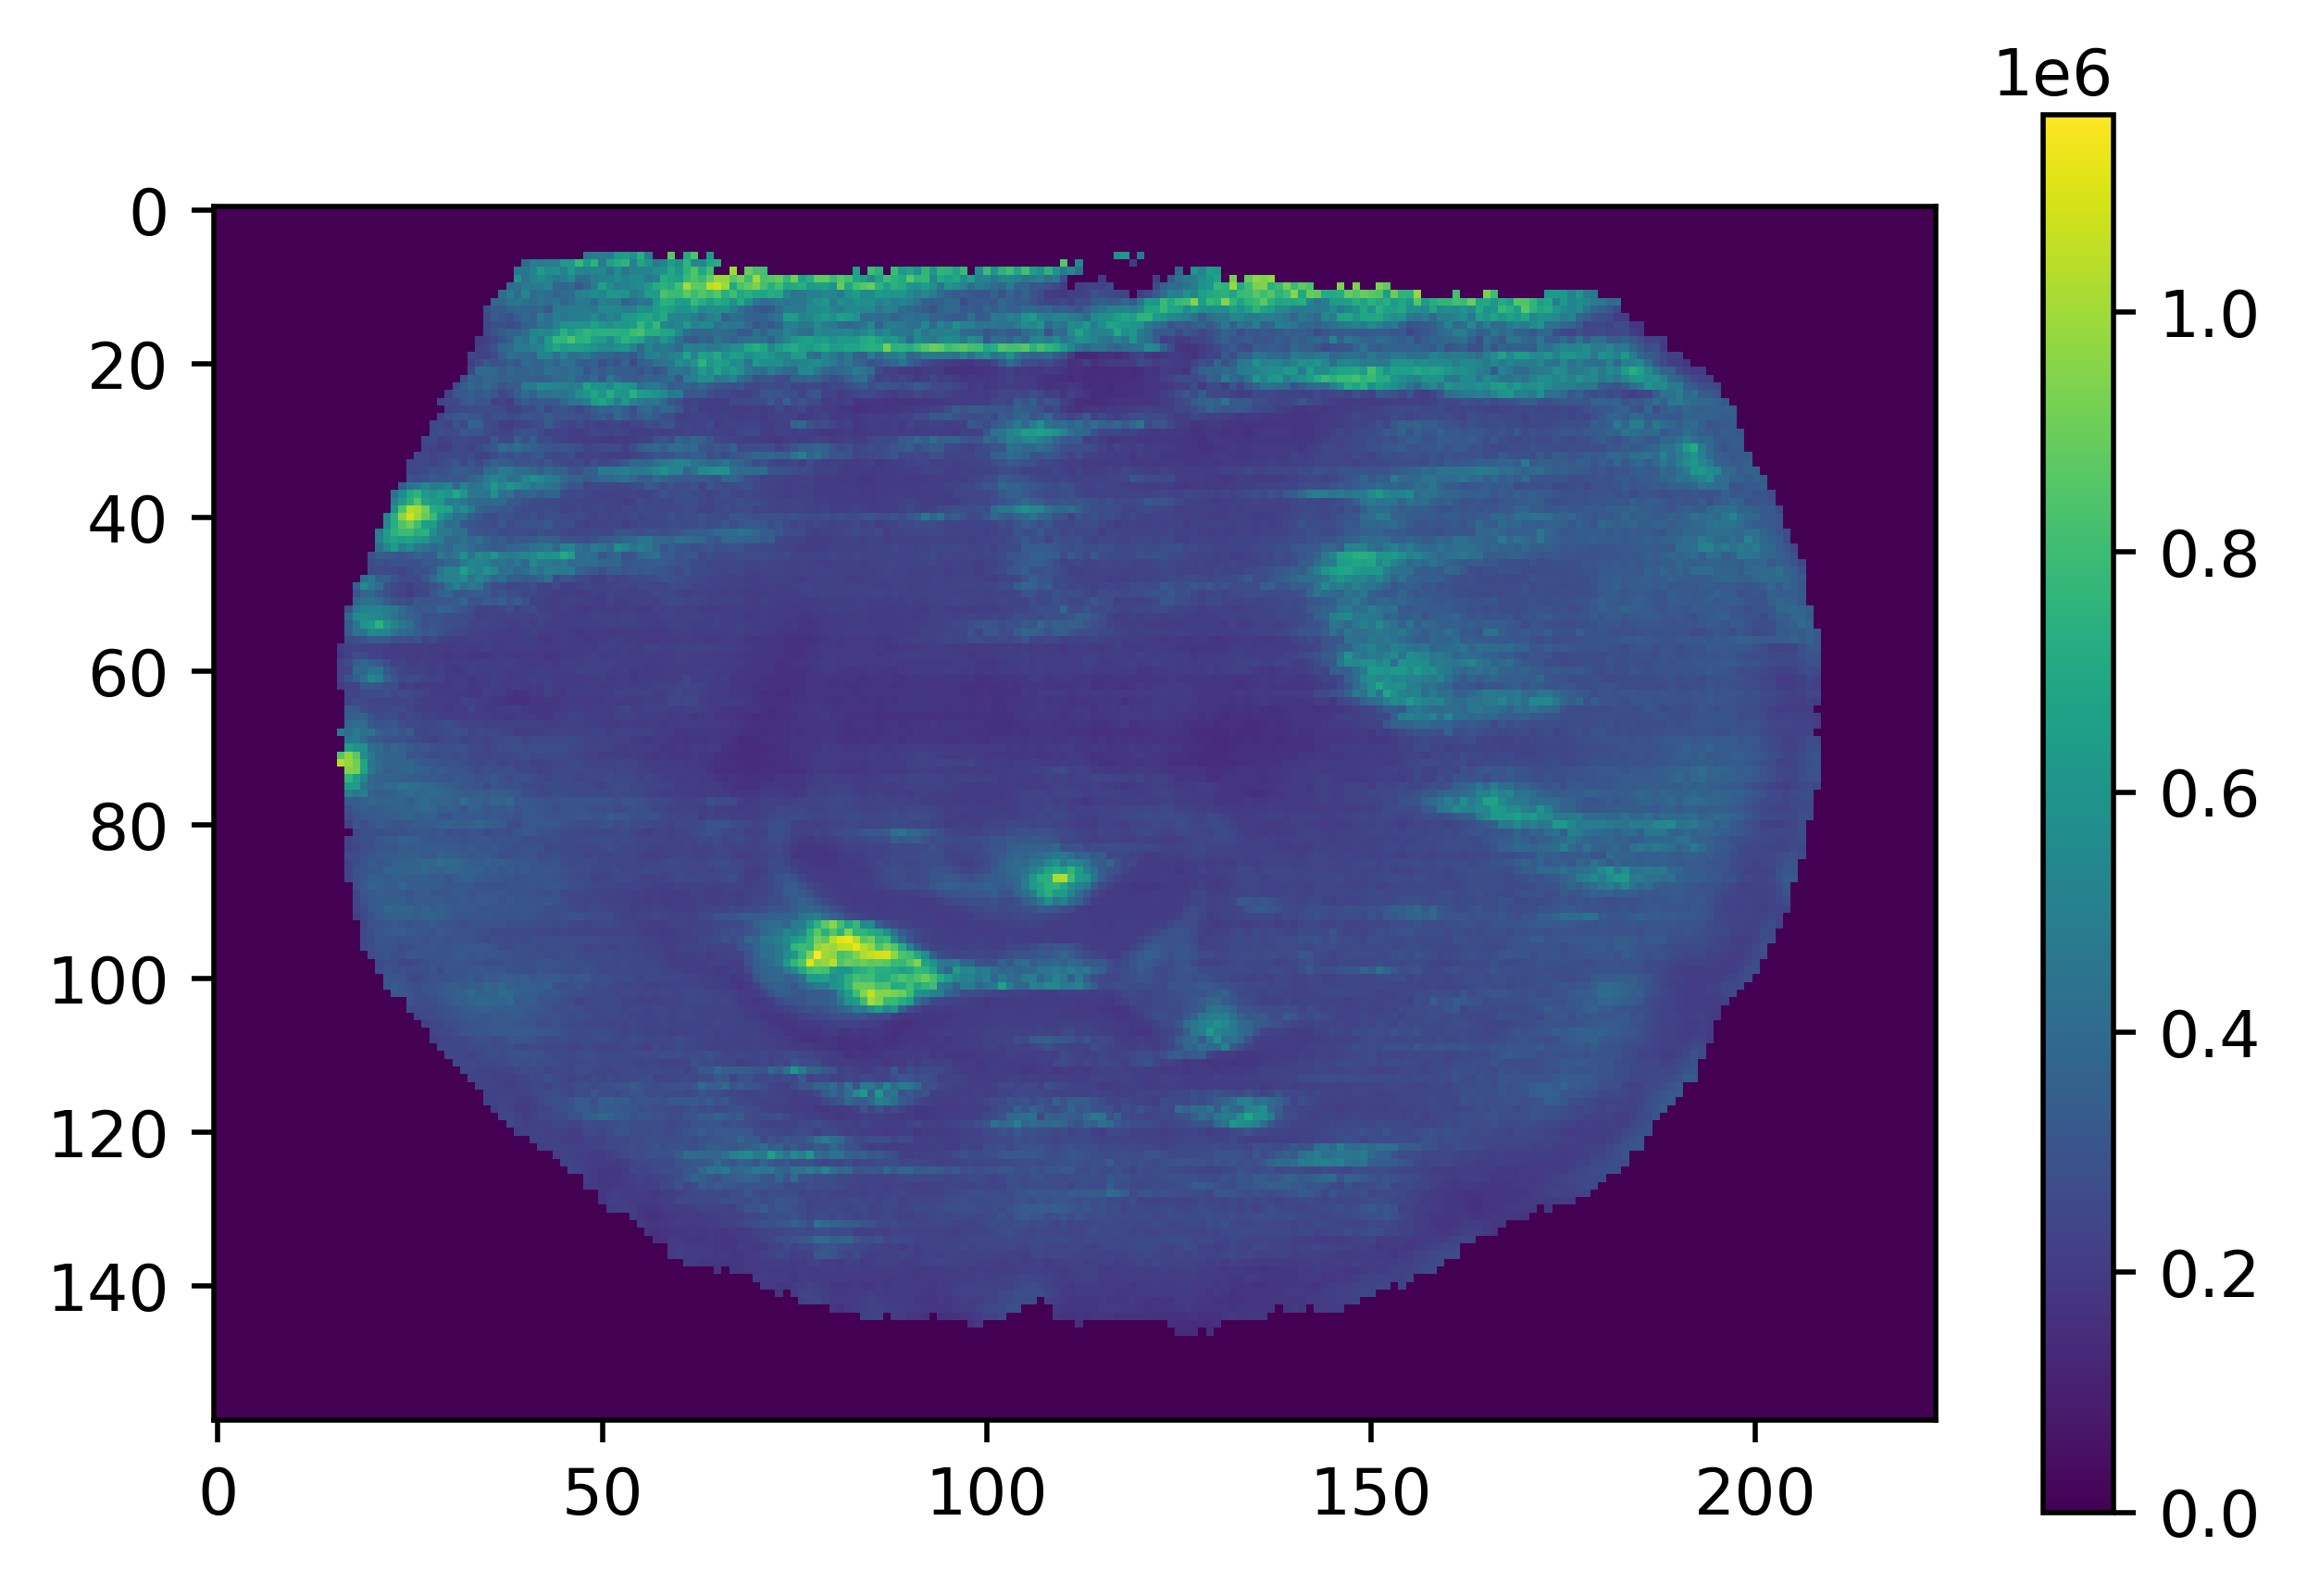

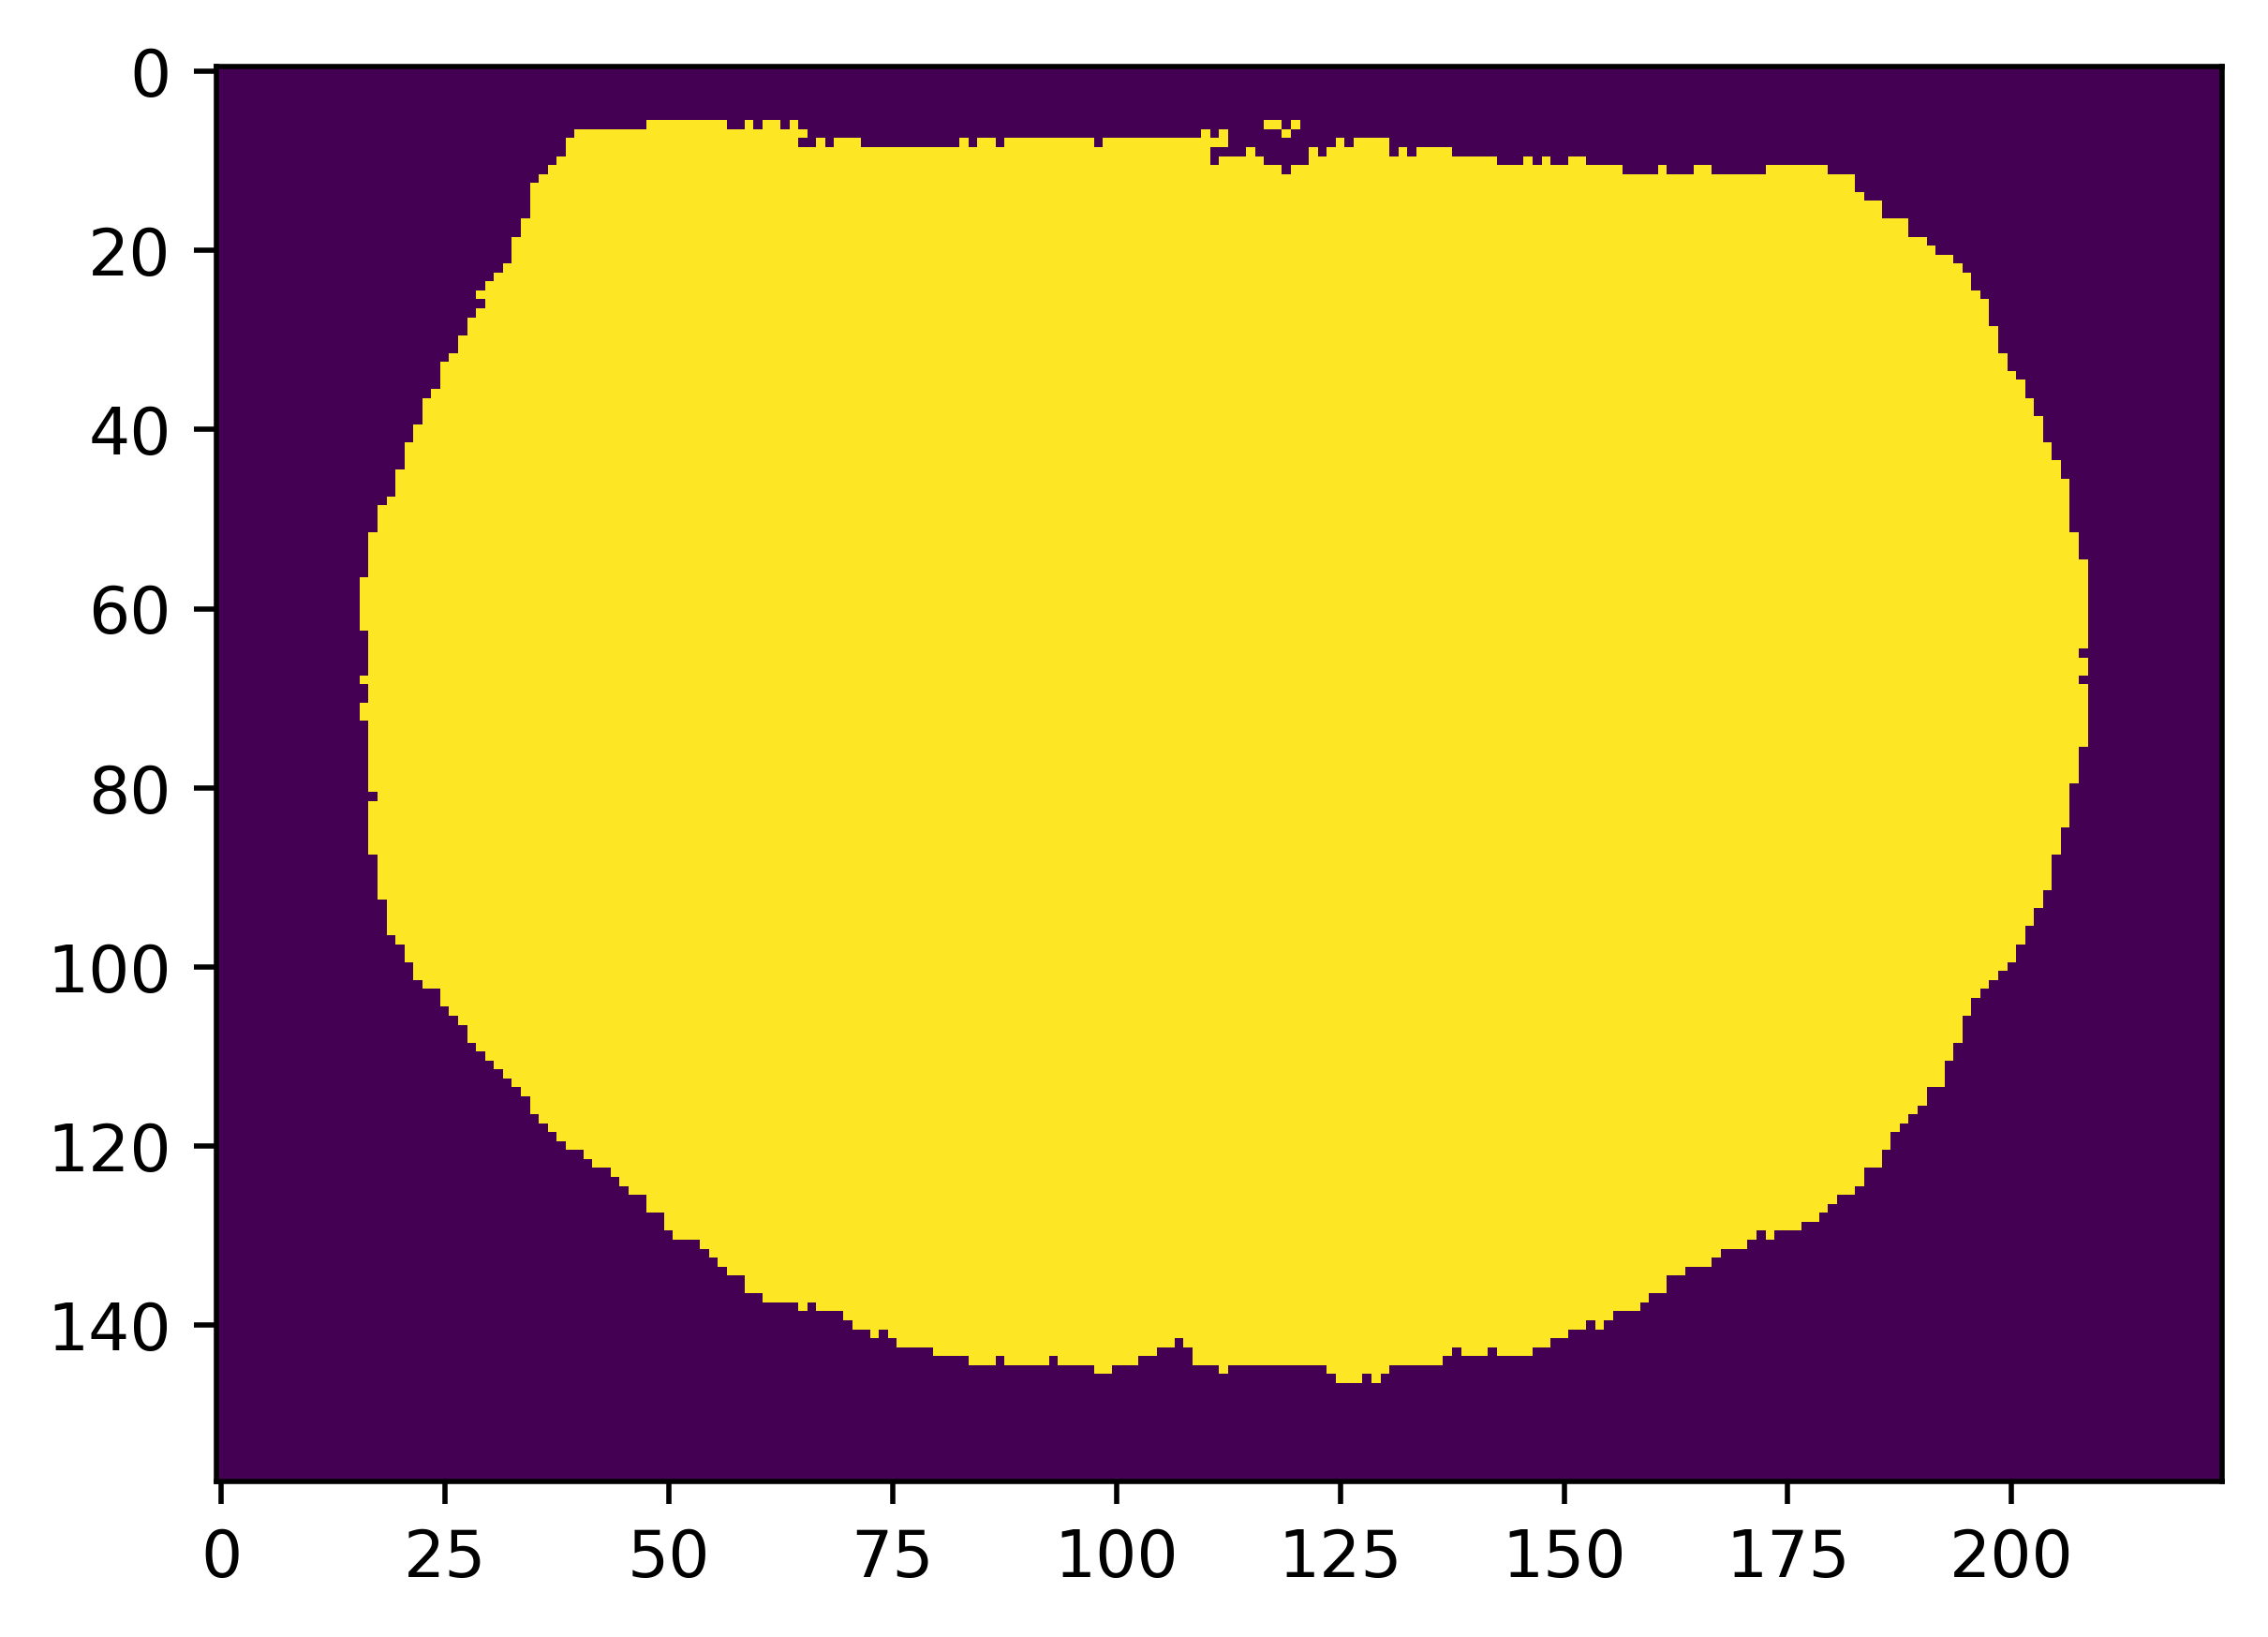

In [16]:
for msiList,fn,bounds in zip(msis,fns,boxBoundaries):
    msi = msiList[0]
    plt.figure()
    plt.imshow(msi.tic_image)
    plt.colorbar()
    #msi.segmentImage(method="TIC_manual",threshold=0.15e6)
    plt.figure()
    plt.imshow(msi.imageBoundary)

In [52]:
msi.tici

AttributeError: 'MSIData' object has no attribute 'ticImage'